# Ad break detection and contextual Ad targeting

Contextual advertising is a form of targeted advertising where the advertisement is matched to the context of the webpage or media being consumed by the user. This process involves three key players: the publisher (website or content owner), the advertiser, and the consumer. Publishers provide the platform and content, while advertisers create ads tailored to the context. Consumers engage with the content, and relevant ads are displayed based on the context, creating a more personalized and relevant advertising experience.

A challenging area of contextual advertising is inserting ads in media content for streaming on video on demand (VOD) platforms. This process traditionally relied on manual tagging, where human experts analyzed the content, identified breaks in the narrative and assigned relevant keywords or categories. However, this approach is time-consuming, subjective, and may not capture the full context or nuances of the content. Traditional AI/ML solutions can automate this process, but they often require extensive training data and can be expensive and limited in their capabilities.

Generative AI, powered by large language models, offers a promising solution to this challenge. By leveraging the vast knowledge and contextual understanding of these models, publishers can automatically generate contextual insights and taxonomies for their media assets. This approach streamlines the process and provides accurate and comprehensive contextual understanding, enabling effective ad targeting and monetization of media archives.

When you are done with this part of the workshop, you'll have created the following metadata for a video:
* a list of high quality ad placement opportunities  or _breaks_ available in the video
* contextual information for the video before and after each break, including classification using the IAB Content Taxonomy that is used by advertisers to classify content for automated placement using Ad Decision Servers.

# Prerequisites

To run this notebook, you need to have run the previous notebook:[01-video-time-segmentation](01-video-time-segmentation.ipynb), where you segmented the video using audio, visual and semantic information.

### Import python packages

In [1]:
from pathlib import Path
import os
import json
import json
import boto3
import json_repair
import copy
from termcolor import colored
from IPython.display import JSON
from IPython.display import Video
from IPython.display import Pretty
from IPython.display import Image as DisplayImage
from lib.frames import VideoFrames
from lib.shots import Shots
from lib.scenes import Scenes
from lib.transcript import Transcript
#from lib.chapters import Chapters
from lib import bedrock_helper as brh
from lib import frame_utils
from lib import util
from PIL import Image, ImageDraw, ImageFont
from io import BytesIO

### Retrieve saved values from previous notebooks
To run this notebook, you need to have run the previous notebook: 00_prerequisites.ipynb, where you installed package dependencies and gathered some information from the SageMaker environment.




In [2]:
store -r


# Find ad placement opportunities by aligning scenes and topics to identify chapters in the narrative

In the [Video segmentation notebook](video-understanding-with-generative-ai-on-aws-main/01-video-time-segmentation.ipynb), we have separately processed the visual and audio cues from the video. Now, we will do one more step to bring them together and ensure that the transcription topics align with the scenes. The last thing you want is to insert an ad during an ongoing conversation or scene. To create alignment, we will iterate over each conversational topic, represented by its start and end timestamps, and a text description summarizing the topic. For each topic, the code identifies the relevant video scenes that overlap or fall within the topic's timestamp range. The output of this process is a list of chapters, where each chapter contains a list of scene IDs representing the video scenes that align with the corresponding audio conversation. After the alignment process, we have combined visual and audio cues into the final chapters. The breaks between chapters are ideal places for ad insertion because they occur between contextual changes in the content of the video. 

In real-world applications, we recommend surfacing these breaks as suggestions to the operator and having a human-in-the-loop step to confirm the final ad placements.

In [3]:
import copy
from lib import frame_utils
import os


class Chapters:
    def __init__(self, topics, scenes, frames):
        self.video_asset_dir = frames.video_asset_dir()
        self.chapters = self.align_scenes_in_chapters(topics, scenes, frames)
        
    def align_scenes_in_chapters(self, topics, scenes, frames):
        scenes = copy.deepcopy(scenes)
    
        chapters = []
        for topic in topics:
            start_ms = topic['start_ms']
            end_ms = topic['end_ms']
            text = topic['reason']

            # find all the frames that align with the conversation topic
            stack = []
            while len(scenes) > 0:
                scene = scenes[0]
                frame_start = scene['start_ms']
                frame_end = scene['end_ms']
    
                if frame_start > end_ms:
                    break
    
                # scenes before any conversation starts
                if frame_end < start_ms:
                    chapter = Chapter(len(chapters), [scene], frames).__dict__
                    chapters.append(chapter)
                    scenes.pop(0)
                    continue
    
                stack.append(scene)
                scenes.pop(0)
    
            if stack:
                chapter = Chapter(len(chapters), stack, frames, text).__dict__
                chapters.append(chapter)
    
        ## There could be more scenes without converations, append them
        for scene in scenes:
            chapter = Chapter(len(chapters), [scene], frames).__dict__
            chapters.append(chapter)
    
        return chapters

class Chapter:
    def __init__(self, chapter_id, scenes, frames, text = ''):
        self.scene_ids = [scene['id'] for scene in scenes]
        self.start_frame_id = scenes[0]['start_frame_id']
        self.end_frame_id = scenes[-1]['end_frame_id']
        self.start_ms = scenes[0]['start_ms']
        self.end_ms = scenes[-1]['end_ms']
        self.id = chapter_id
        self.text = text
        #folder = os.path.join(frames.video_asset_dir(), 'chapters')
        #os.makedirs(folder, exist_ok=True) 
        self.composite_images = frames.create_composite_images(frames.frames[self.start_frame_id:self.end_frame_id+1], 'chapters', prefix="chapter_")
        
        return 


In [4]:
video['chapters'] = Chapters(video['topics'], video['scenes'].scenes, video['frames'])

Examine the results

In [5]:
display(JSON(video['chapters'].chapters))

<IPython.core.display.JSON object>

#### Visualize the chapters

Now let's visualize the frames and the text for each of the chapters.  These will be the input to our prompt to generate contextual information for the ad breaks. Note that some chapters will not have any text associated with them.

<div class="alert alert-block alert-info">
💡 Use the scroll bar in the output box to view the chapters.  Some chapters contain more frames than can fit on a single composite image, so the may be multiple composite images displayed for each chapter.
</div>



Chapter 0: frames 0 to 0, scenes 0 to 0 =======


Chapter Text (conversation topic): None


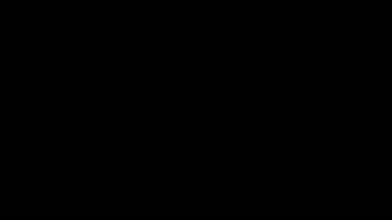


Chapter 1: frames 1 to 14, scenes 1 to 1 =======


Chapter Text (conversation topic): None


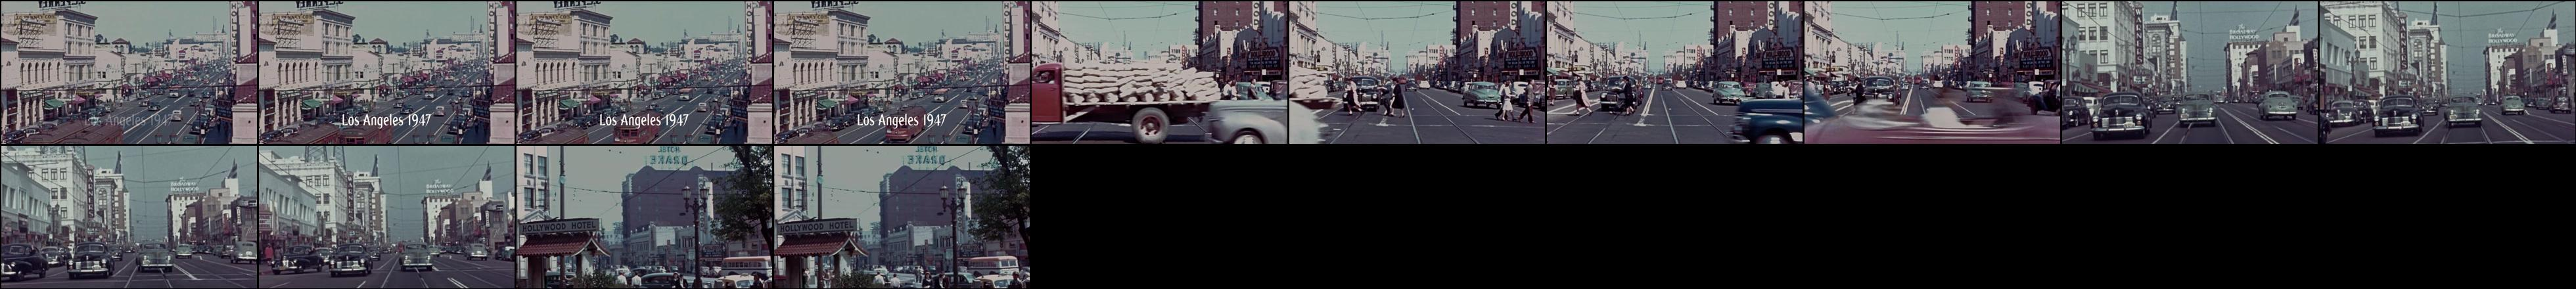


Chapter 2: frames 15 to 16, scenes 2 to 2 =======


Chapter Text (conversation topic): None


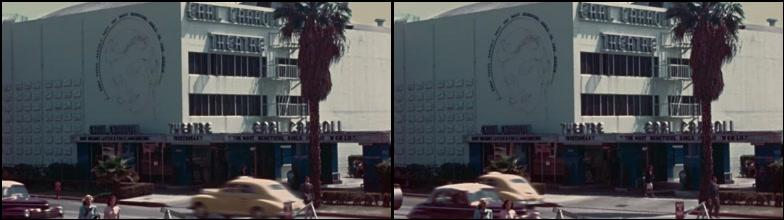


Chapter 3: frames 17 to 19, scenes 3 to 3 =======


Chapter Text (conversation topic): None


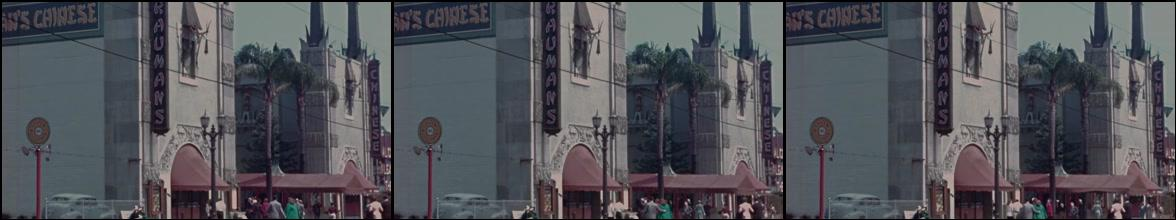


Chapter 4: frames 20 to 22, scenes 4 to 4 =======


Chapter Text (conversation topic): None


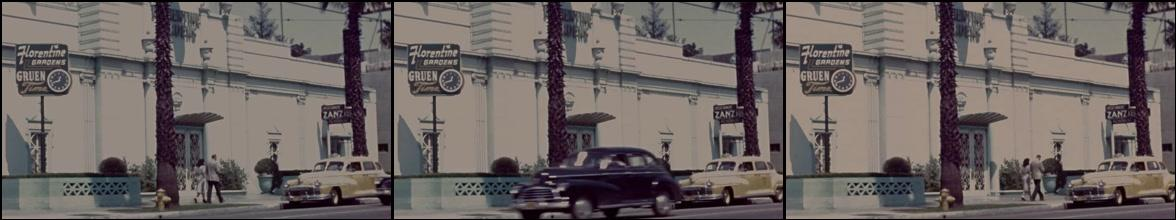


Chapter 5: frames 23 to 197, scenes 5 to 6 =======


Chapter Text: This section discusses the disappearance of three men - a school teacher, an insurance salesman, and a retired person - in the area near El Matador beach. It mentions a witness who claims to have seen a strange event involving a man on a rock, a woman in a white dress, and bizarre weather conditions.


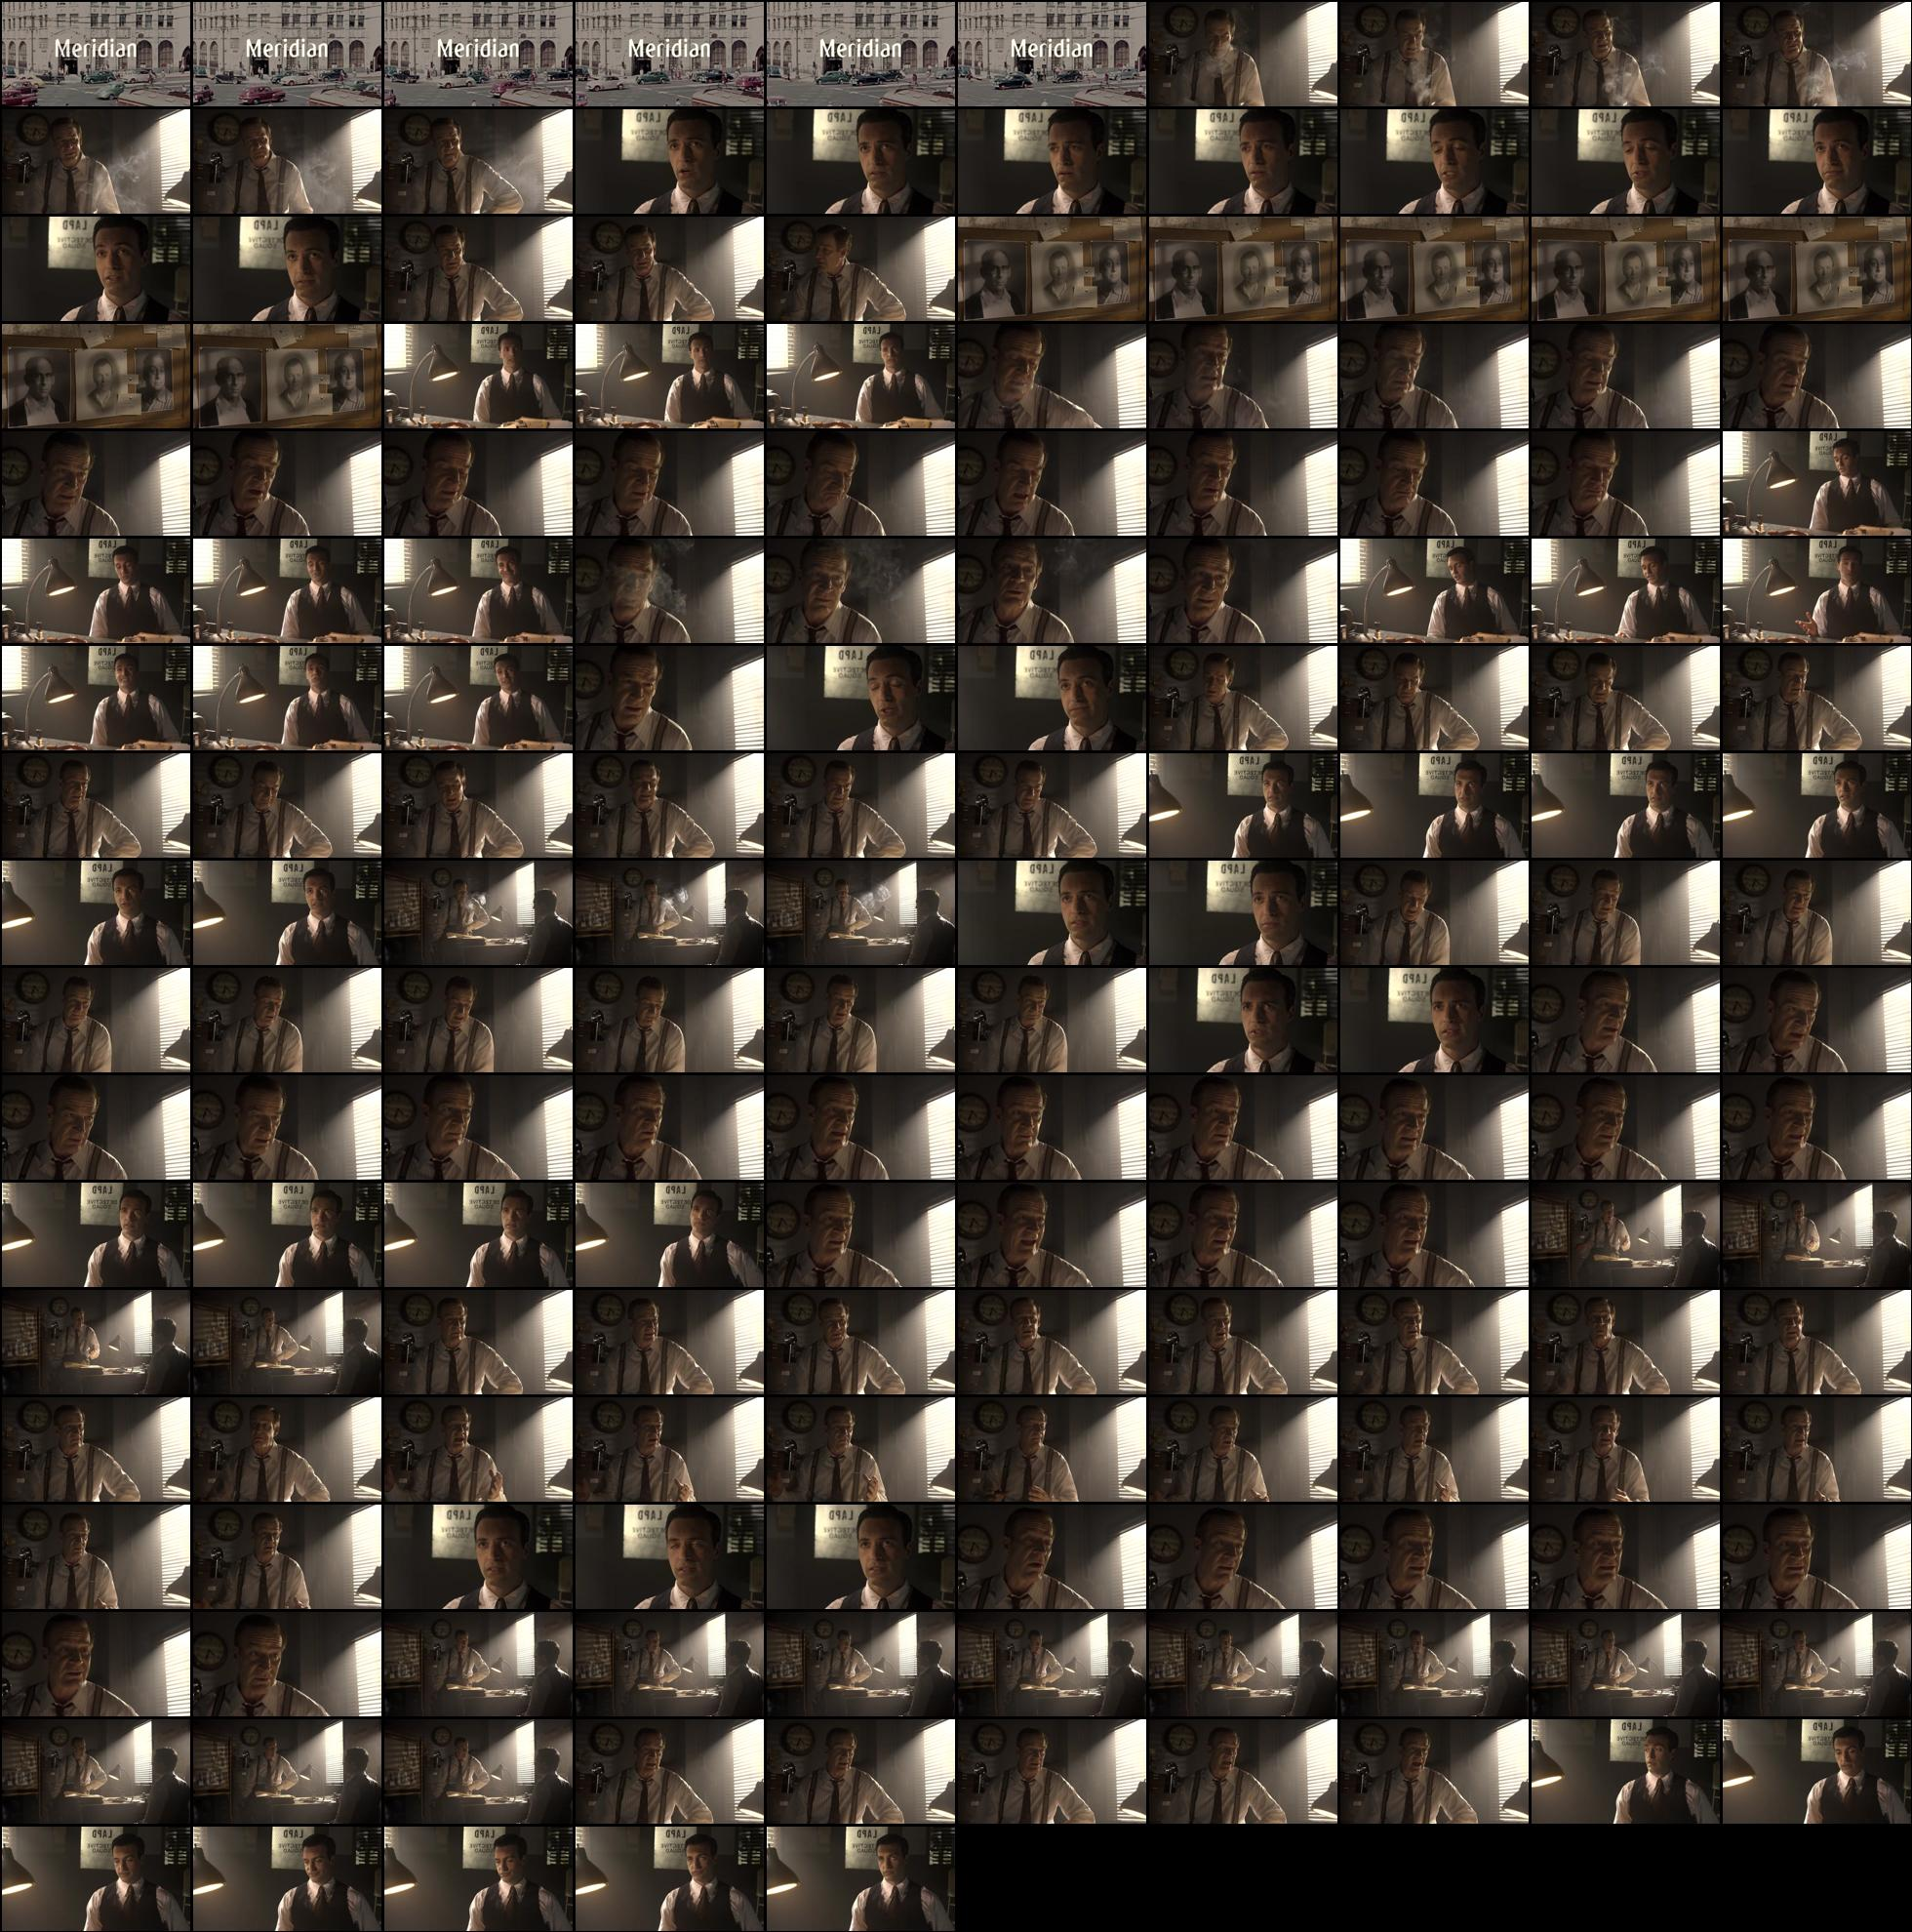


Chapter 6: frames 198 to 271, scenes 7 to 8 =======


Chapter Text: This part is the witness's detailed account of what he saw - a man on the rock looking around, sudden thunderstorm, the man disappearing and a woman in a white dress appearing on the rock and staring at the witness.


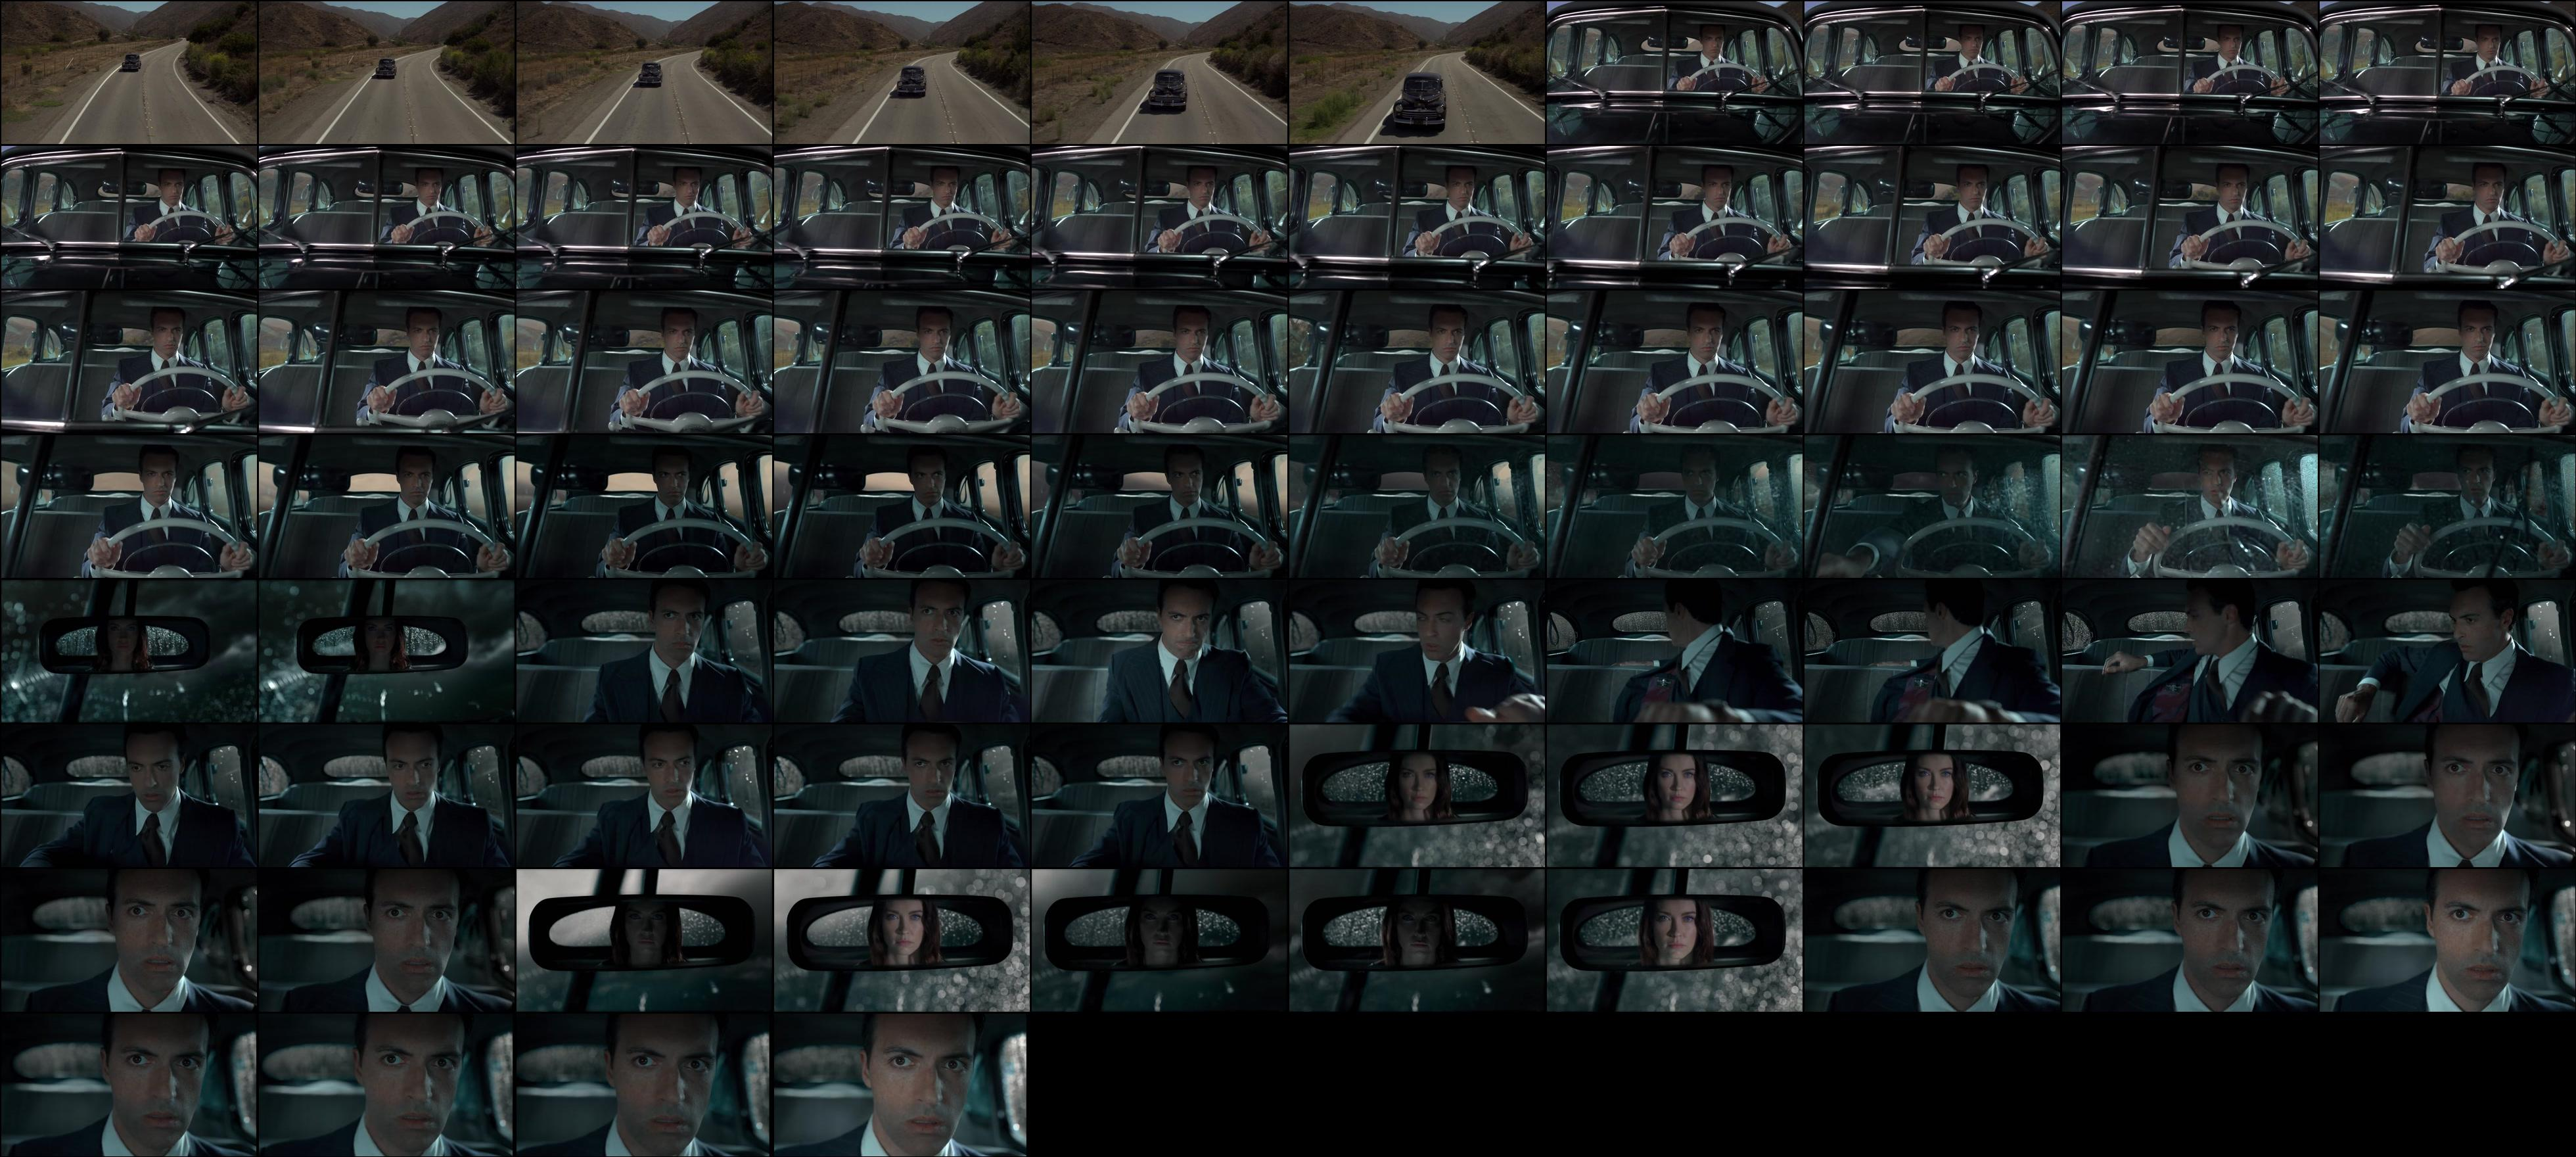


Chapter 7: frames 272 to 335, scenes 9 to 10 =======


Chapter Text: Here the main person is summarizing the witness's strange story and expressing disbelief, but also dispatching someone (Detective Sullivan) to investigate further.


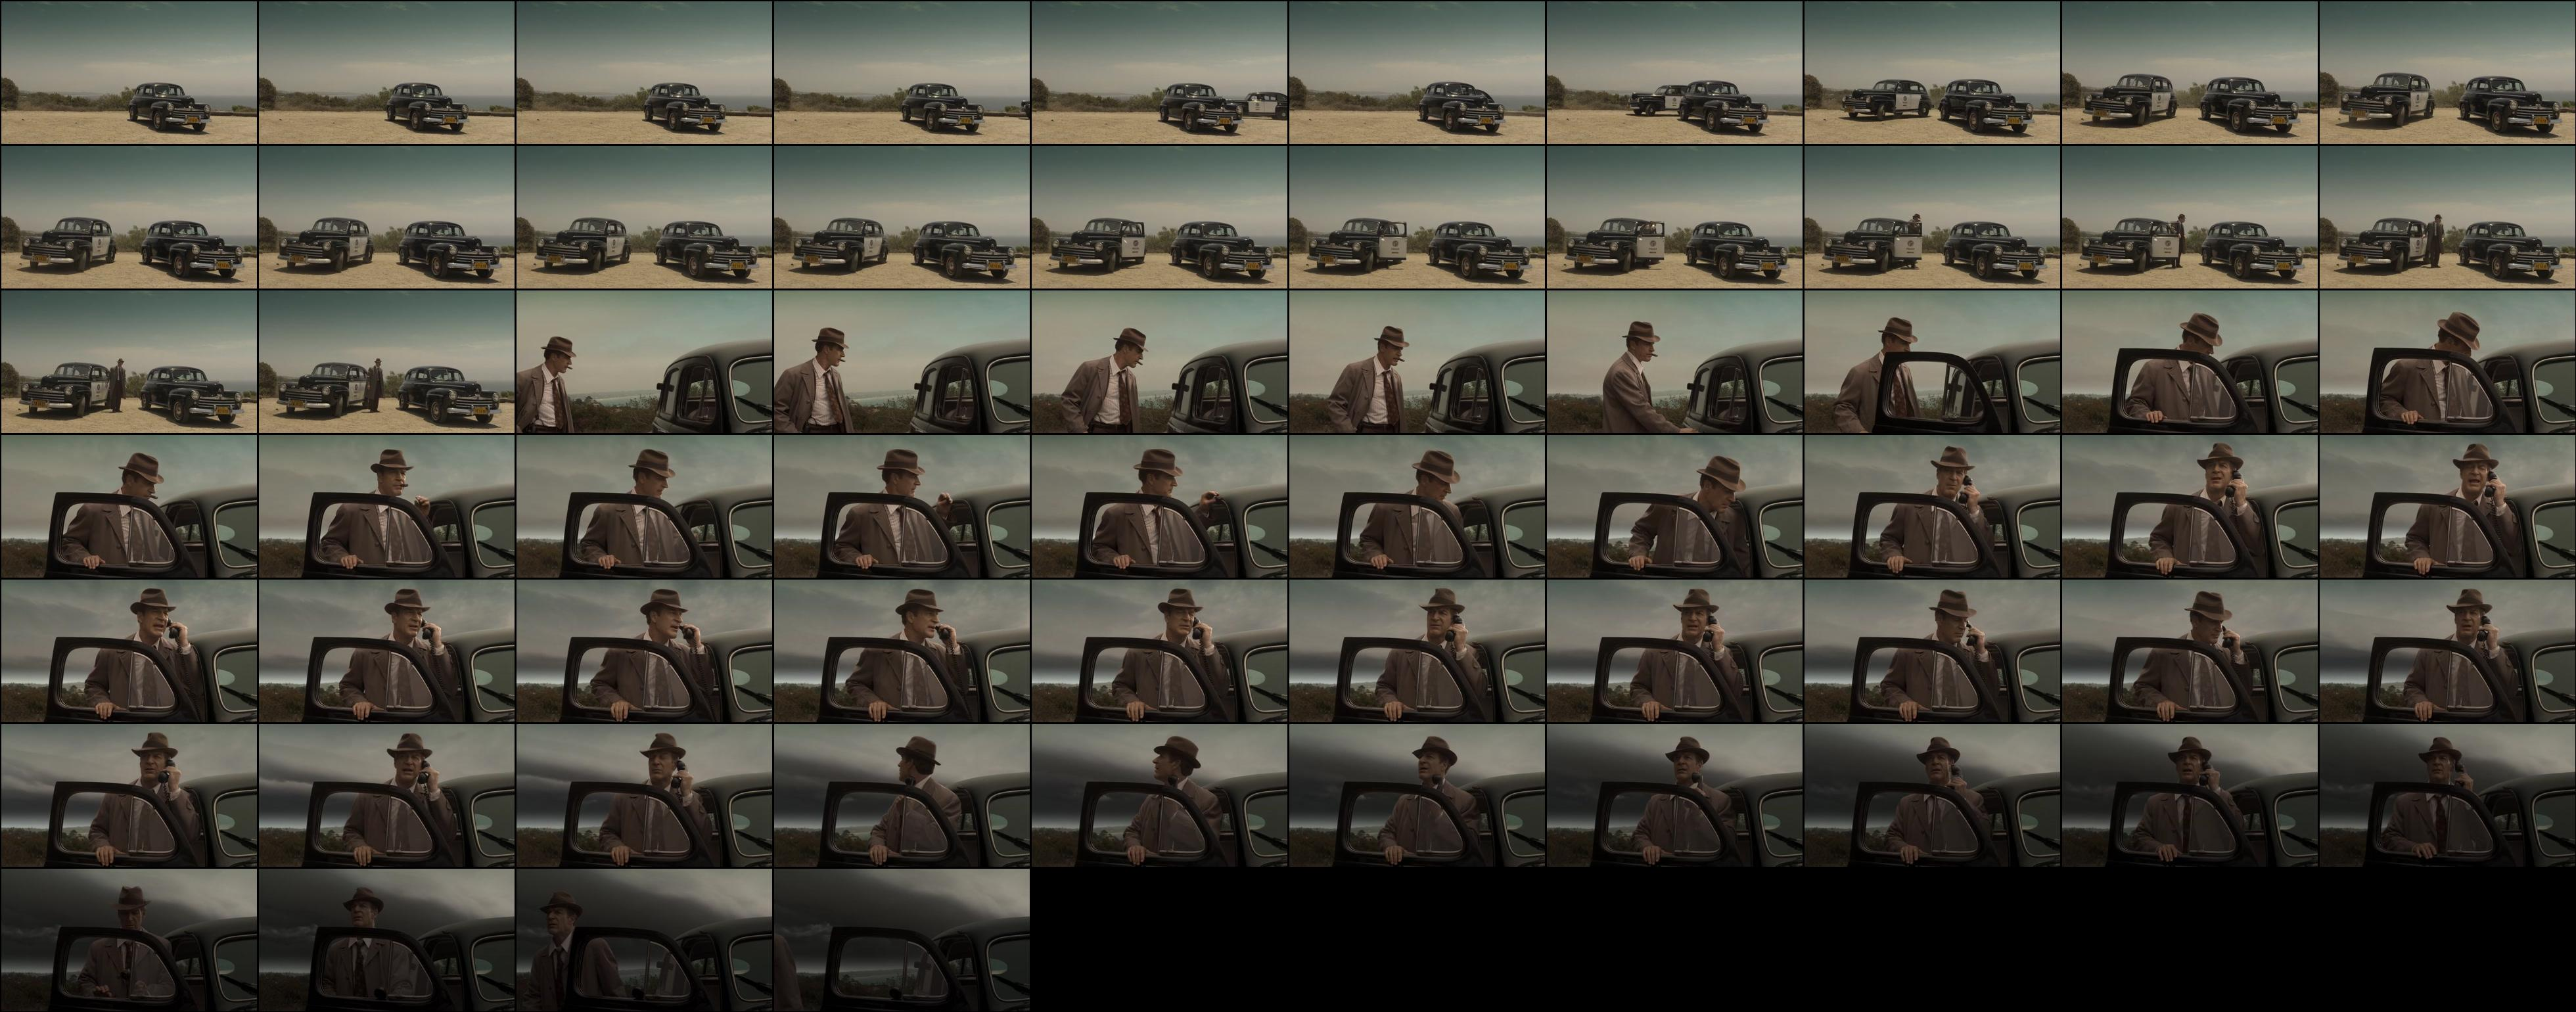


Chapter 8: frames 336 to 437, scenes 11 to 11 =======


Chapter Text (conversation topic): None


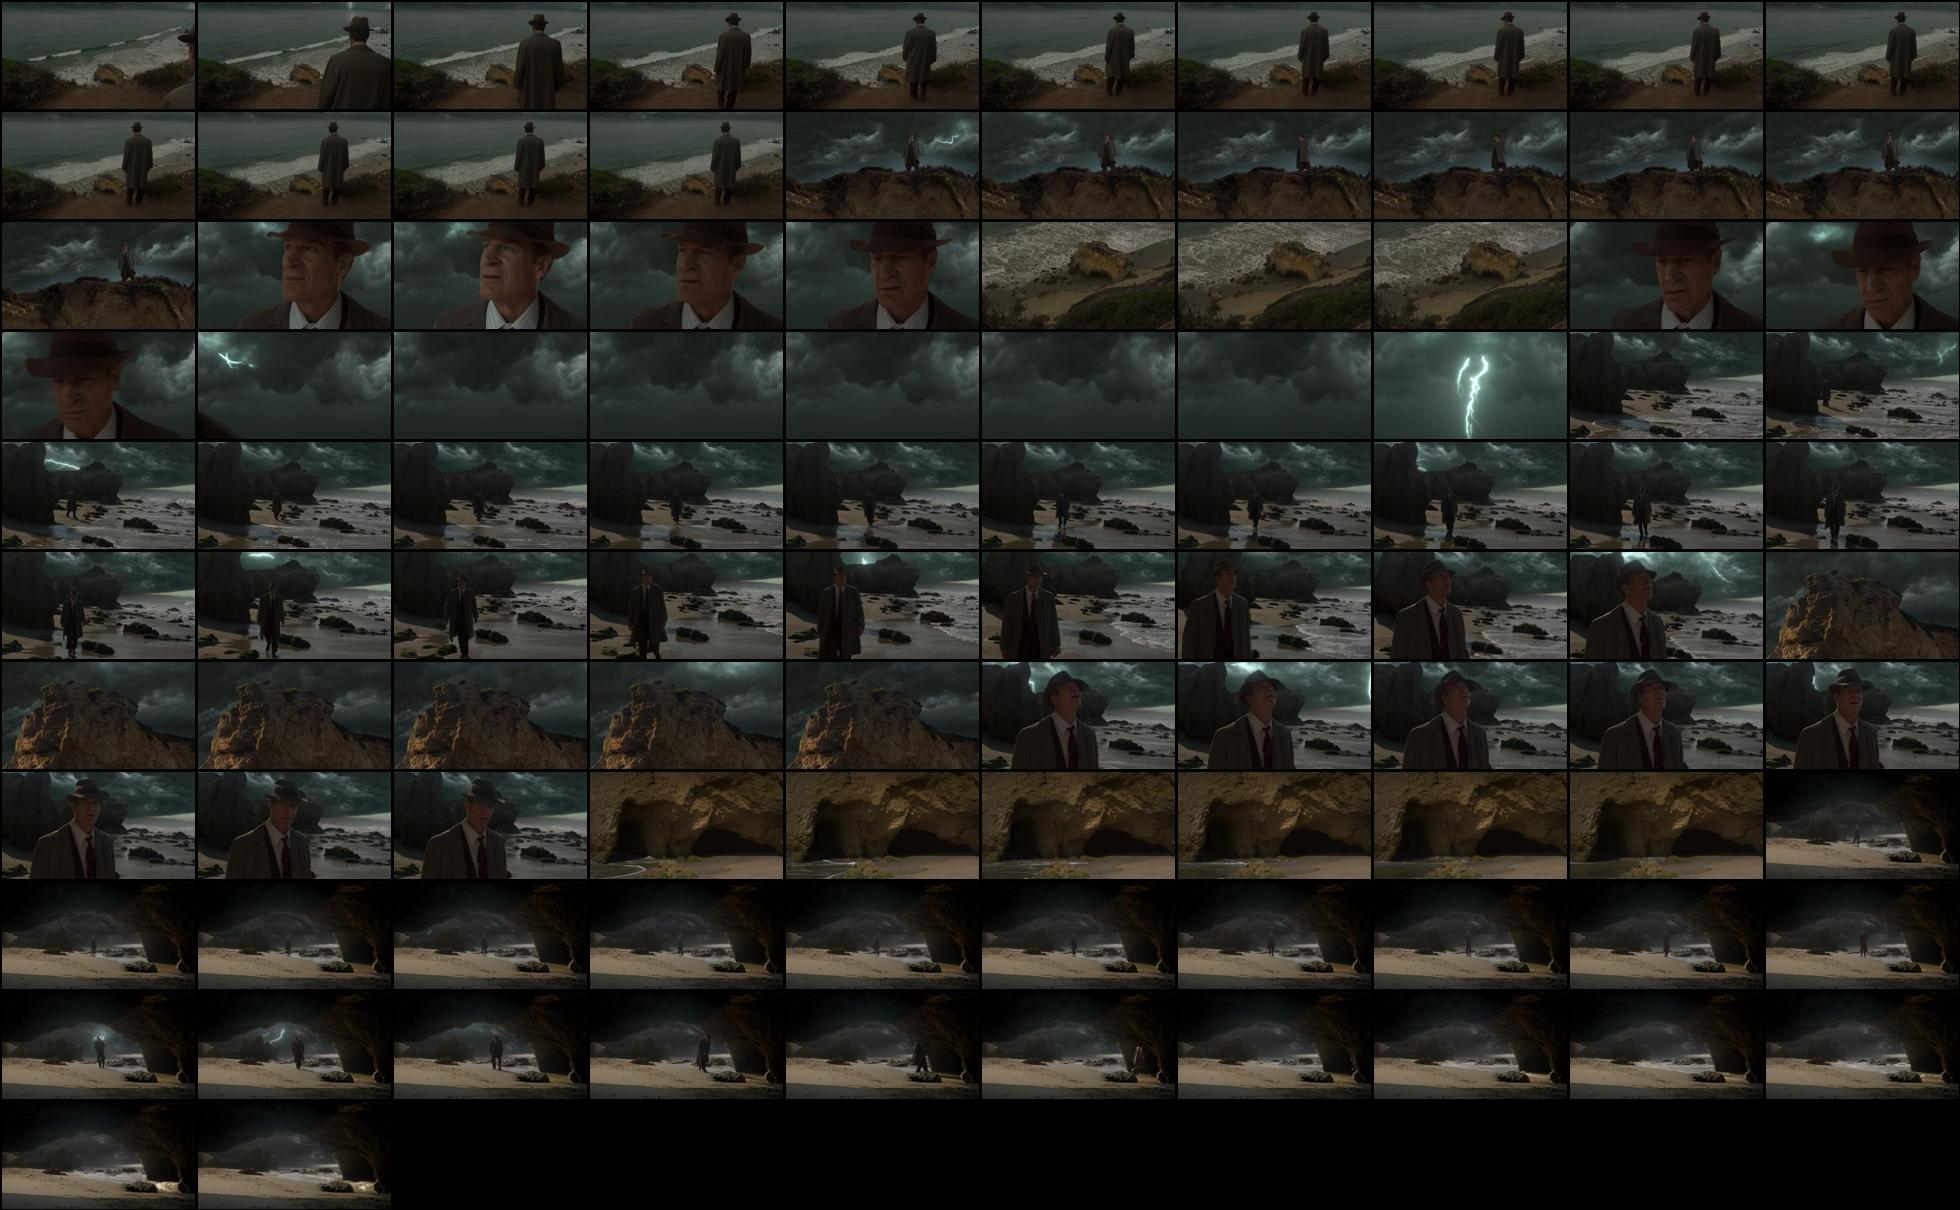


Chapter 9: frames 438 to 566, scenes 12 to 12 =======


Chapter Text: This seems to be a separate incident where someone is being apprehended by the police (possibly Detective Sullivan) at the El Matador location.


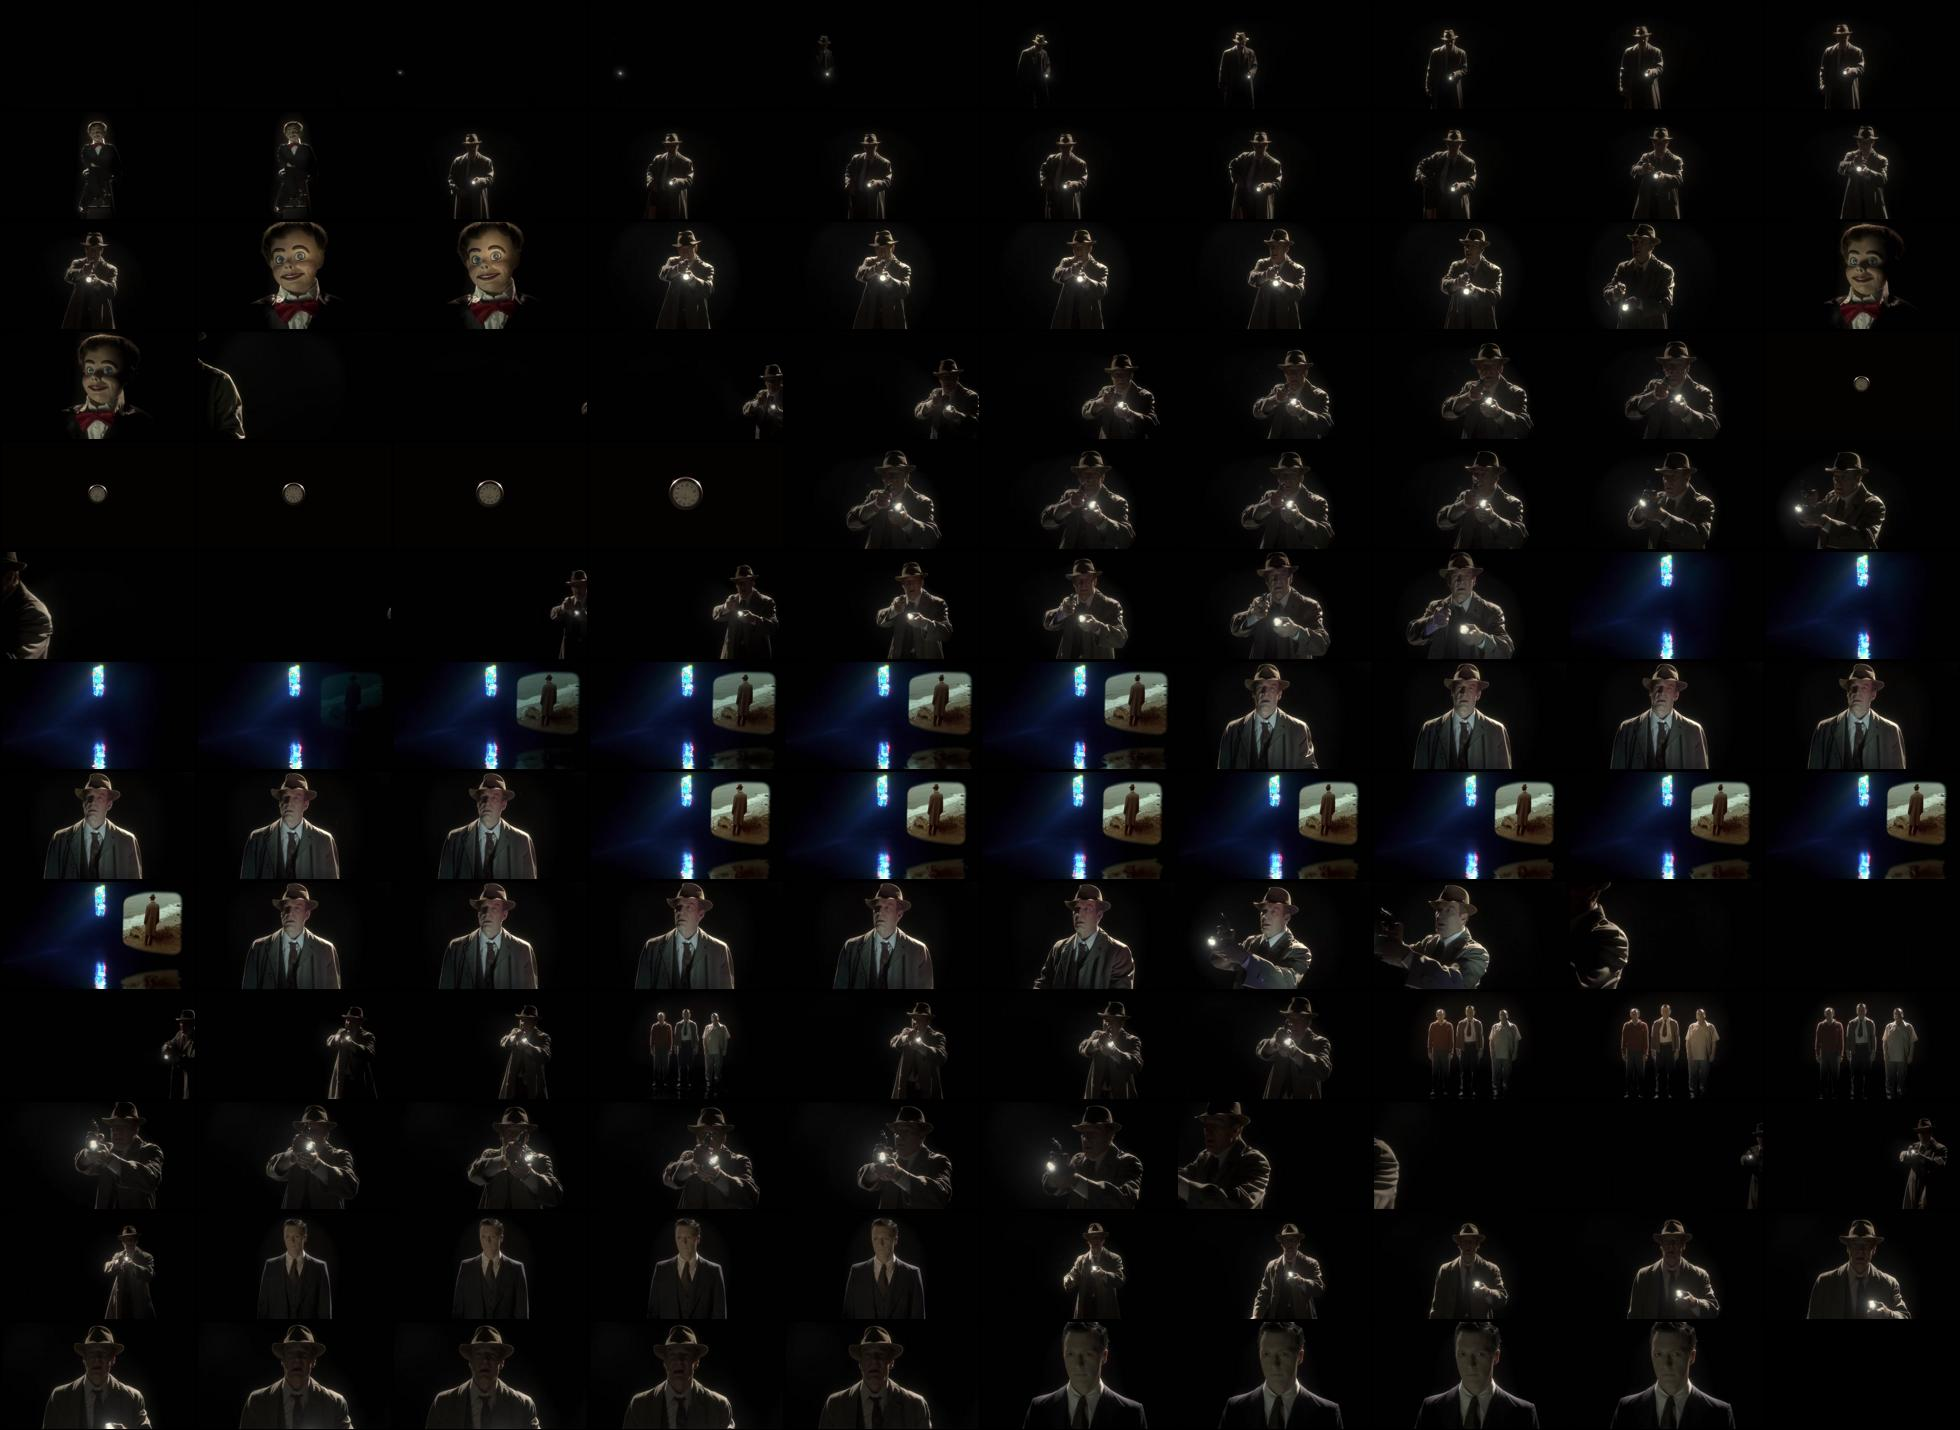


Chapter 10: frames 567 to 569, scenes 13 to 13 =======


Chapter Text (conversation topic): None


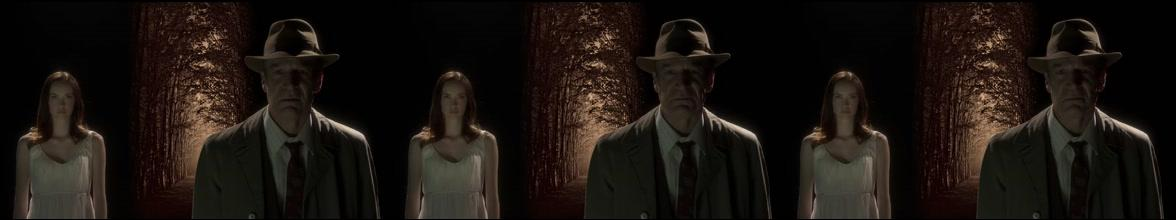


Chapter 11: frames 570 to 577, scenes 14 to 14 =======


Chapter Text (conversation topic): None


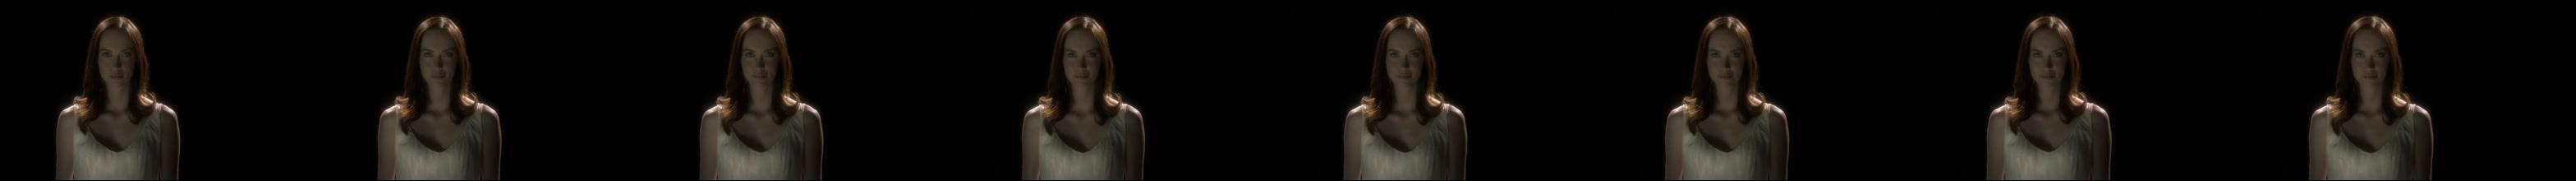


Chapter 12: frames 578 to 580, scenes 15 to 15 =======


Chapter Text (conversation topic): None


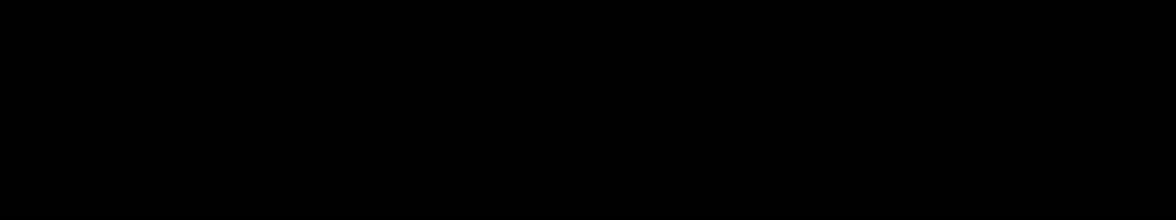


Chapter 13: frames 581 to 620, scenes 16 to 16 =======


Chapter Text (conversation topic): None


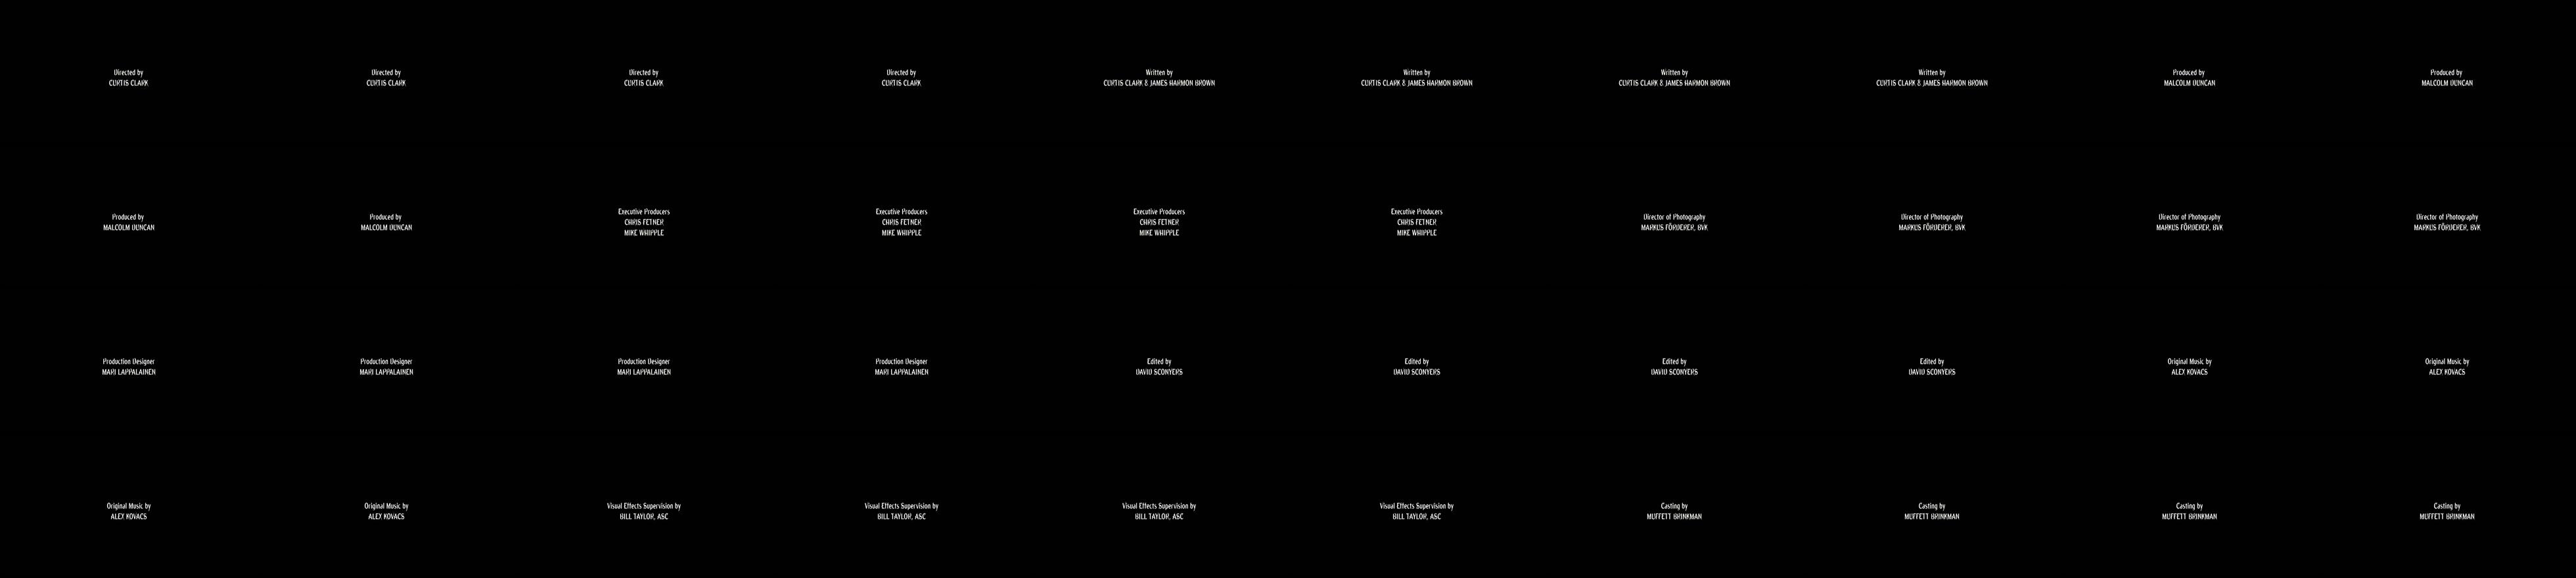


Chapter 14: frames 621 to 624, scenes 17 to 17 =======


Chapter Text (conversation topic): None


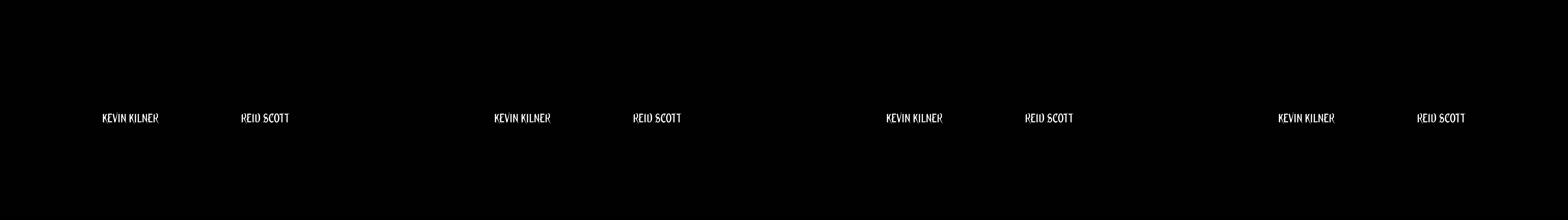


Chapter 15: frames 625 to 628, scenes 18 to 18 =======


Chapter Text (conversation topic): None


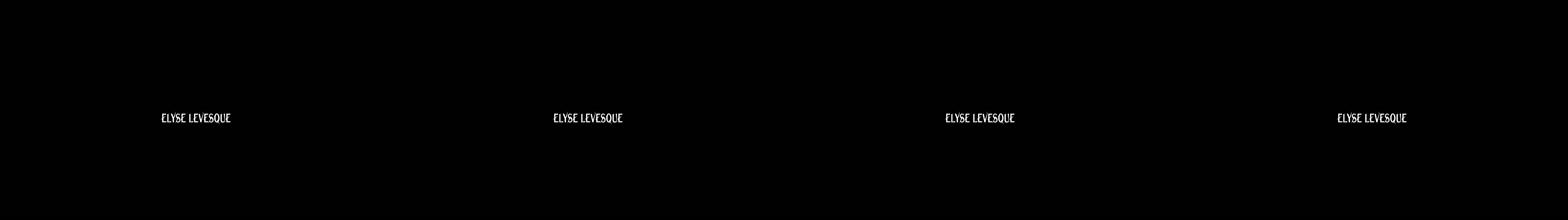


Chapter 16: frames 629 to 632, scenes 19 to 19 =======


Chapter Text (conversation topic): None


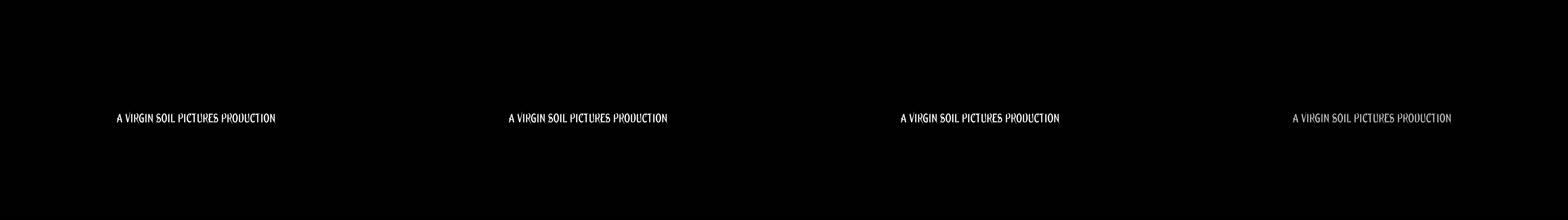


Chapter 17: frames 633 to 634, scenes 20 to 20 =======


Chapter Text (conversation topic): None


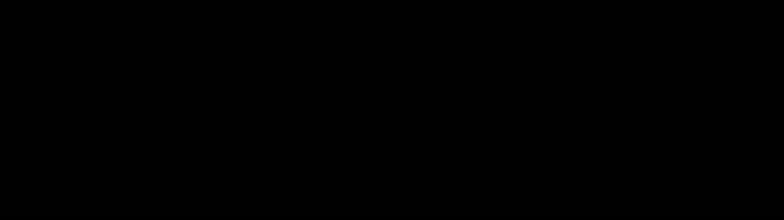


Chapter 18: frames 635 to 697, scenes 21 to 21 =======


Chapter Text (conversation topic): None


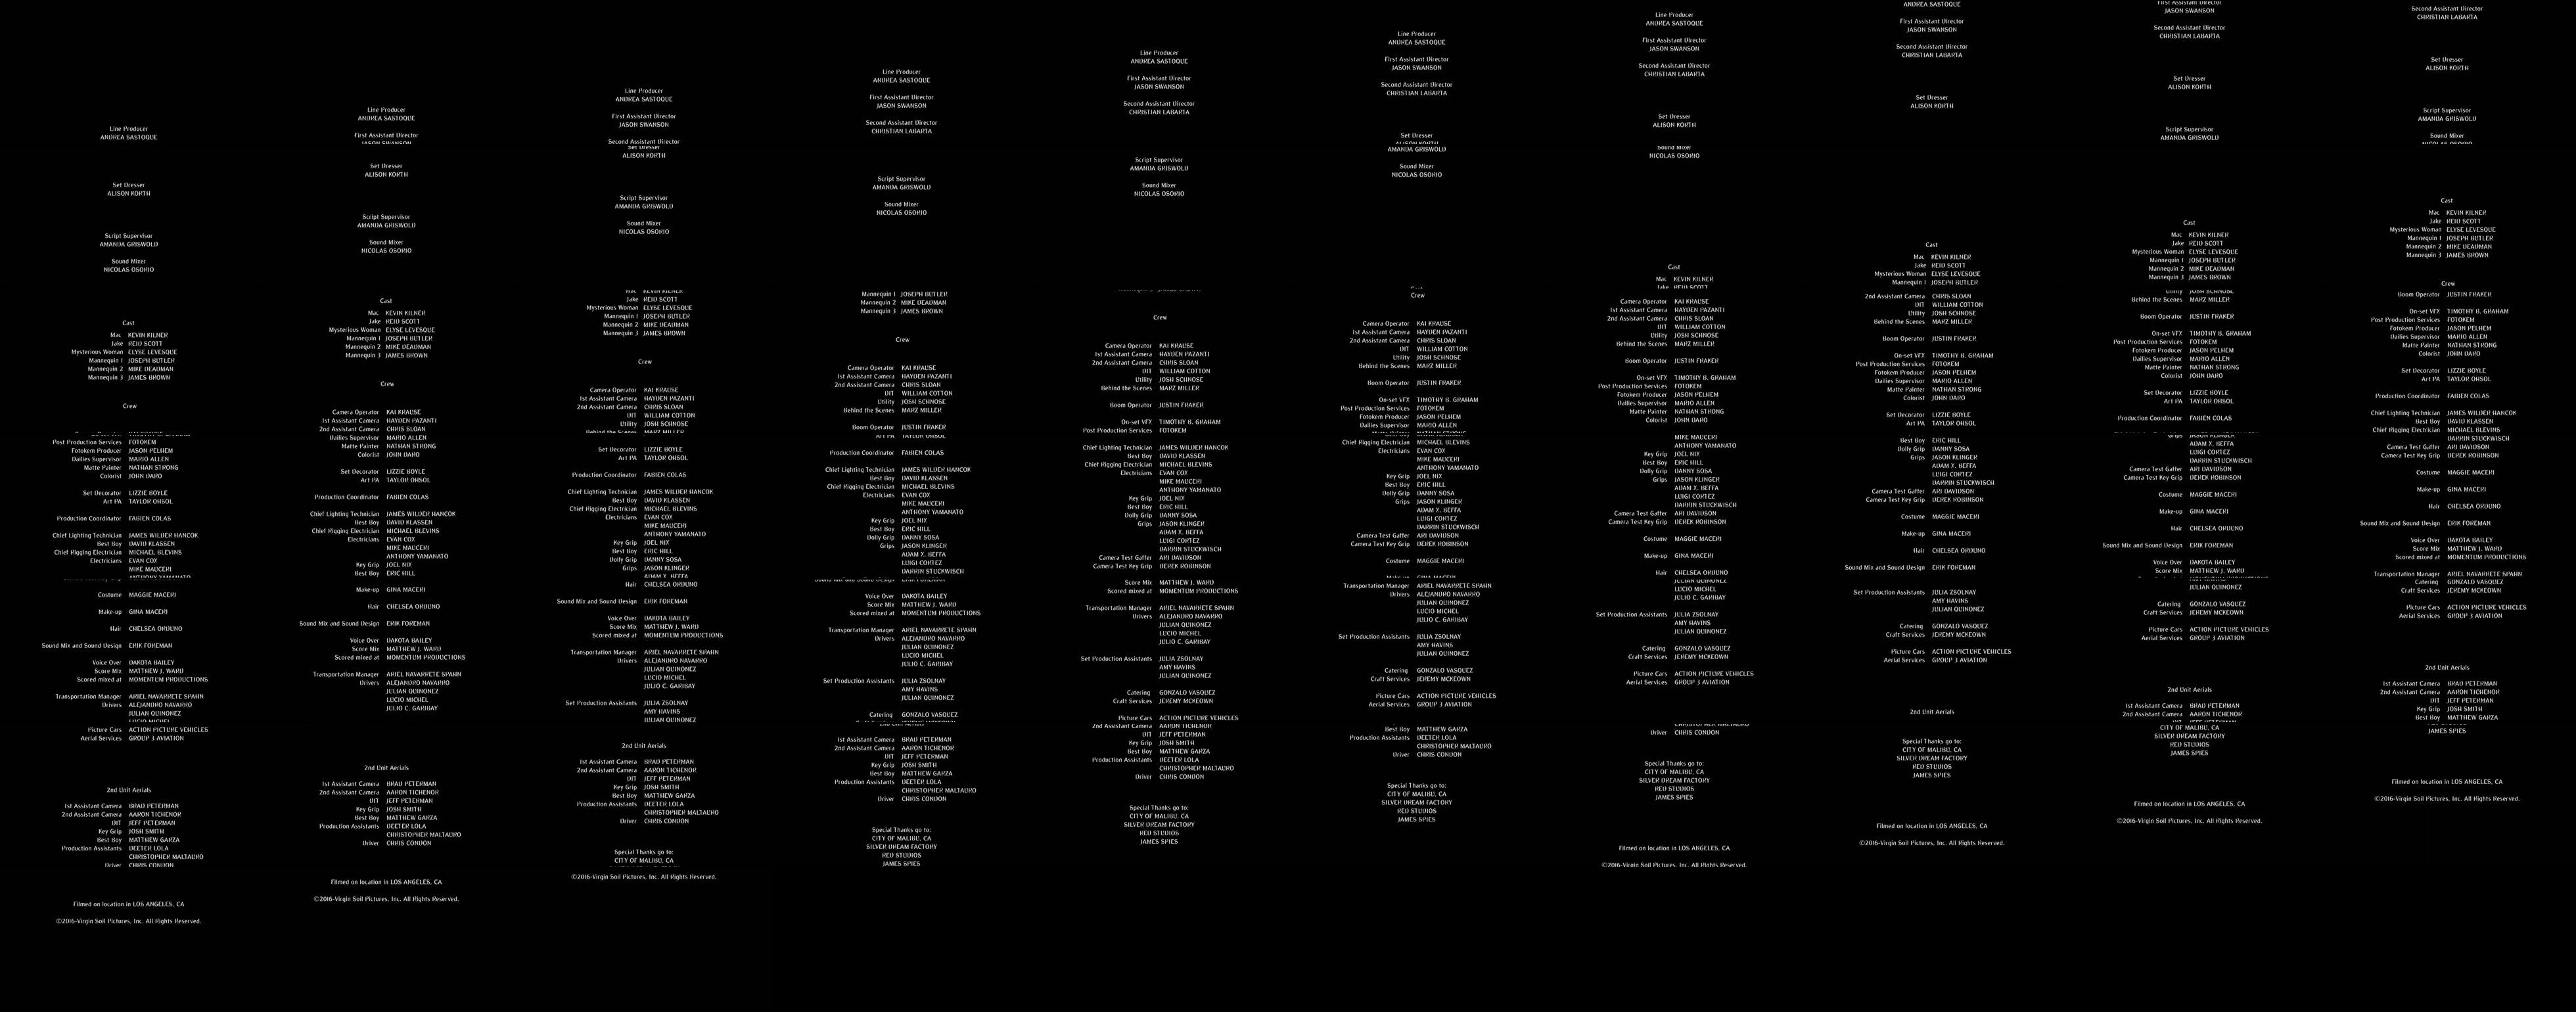


Chapter 19: frames 698 to 718, scenes 22 to 22 =======


Chapter Text (conversation topic): None


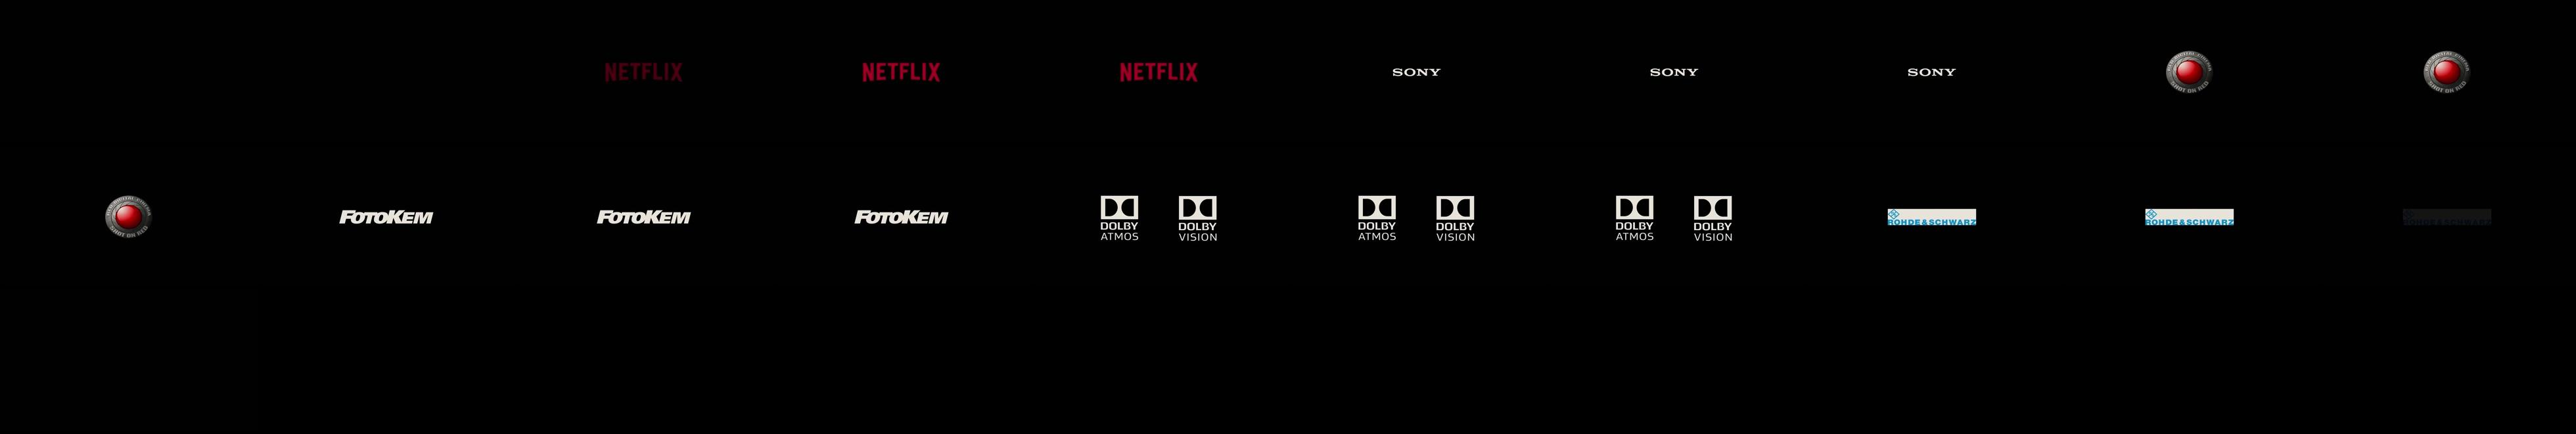

In [6]:
# visualize the chapters

STOP=10
for counter, b in enumerate(video["chapters"].chapters):
    print(f'\nChapter {counter}: frames {b["start_frame_id"] } to {b["end_frame_id"] }, scenes { b["scene_ids"][0] } to { b["scene_ids"][-1] } =======\n')
    if len(b["text"]) > 0: 
        print(f'\nChapter Text: { b["text"] }')
    else:
        print(f'\nChapter Text (conversation topic): None')

    video['frames'].display_frames(start=b['start_frame_id'], end=b['end_frame_id']+1)

    # ALTERNATIVE: view the composite images that will be used in prompts
    #for image_file in b['composite_images']:
    #    display(DisplayImage(filename=image_file['file'], height=100))
    #if counter == STOP:
    #    break

# Generate chapter level contextual information 

The last step is to send both the visually and audio-aligned data to Claude 3 Sonnet to generate contextual information for each topic. This approach that takes advantage of the multimodal capabilities of the Claude 3 family of models. From our testing, these models have demonstrated the ability to capture minute details from large images and follow image sequences when provided with appropriate instructions.

To prepare the input for Claude3 Haiku, we first assemble video frames associated with each topic and create a composite image grid. Through our experimentation, we have found that the optimum image grid ratio is 7 rows by 4 columns, which will assemble a 1568 x 1540 pixel image that fits under Claude's 5 MB image file size limit while still preserving enough detail in each individual frame tile. Furthermore, you can also assemble multiple images if needed.

Subsequently, the composite images, the transcription, the IAB Content taxonomy definitions, and GARM taxonomy definitions are fed into the prompt to generate descriptions, sentiment, IAB taxonomy, GARM taxonomy, and other relevant information in a single query to the Claude3 Haiku model. Not only that, but we can adapt this approach to any taxonomy or custom labeling use cases without the need to train a model each time. This is where the true power of this approach lies. The final output can be presented to a human reviewer for final confirmation if needed. Here is an example of a composite image grid and the corresponding contextual output for a specific topic.


## Download the IAB Content Taxonomy definition

In [7]:
iab_file = 'iab_content_taxonomy_v3.json'
url = f"https://dx2y1cac29mt3.cloudfront.net/iab/{iab_file}"

!curl {url} -o {iab_file}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 98444  100 98444    0     0   954k      0 --:--:-- --:--:-- --:--:--  961k


In [8]:
def load_iab_taxonomies(file):
    with open(file) as f:
        iab_taxonomies = json.load(f)
    return iab_taxonomies


## Generate contextual metadata for each chapter segment

==== Chapter #00: Contextual information ======


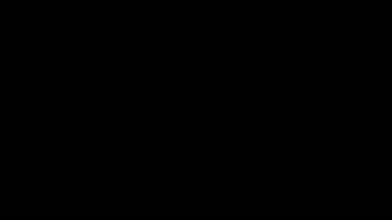

Description: The scene depicts a dark silhouette or outline against a plain background, with no discernible details or context. (90%)
Sentiment: Neutral (95%)
Iab_taxonomy: None (100%)
Garm_taxonomy: None (100%)
Brands_and_logos: None
Relevant_tags: silhouette, outline, dark, plain background, minimalist


==== Chapter #01: Contextual information ======


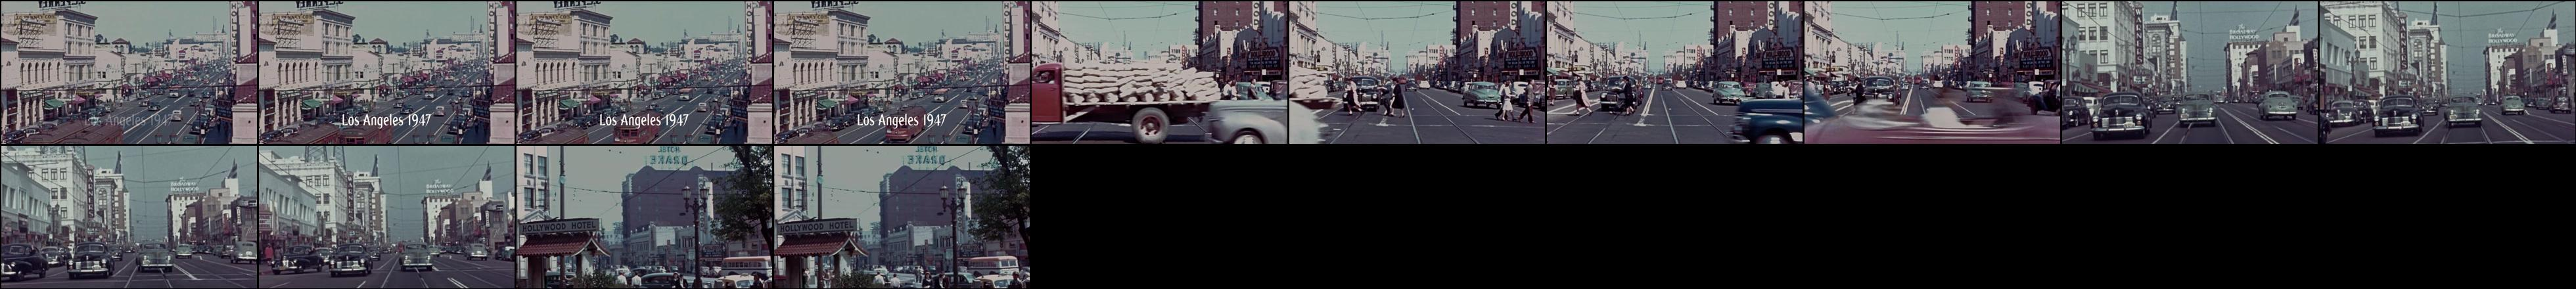

Description: The scene depicts a crowded street in Los Angeles in 1947, with vintage cars and pedestrians on the road. The buildings and architecture appear to be from that era. (95%)
Sentiment: Neutral (90%)
Iab_taxonomy: Travel (85%)
Garm_taxonomy: None (95%)
Brands_and_logos: None
Relevant_tags: vintage cars, 1940s, city street, historical, Los Angeles


==== Chapter #02: Contextual information ======


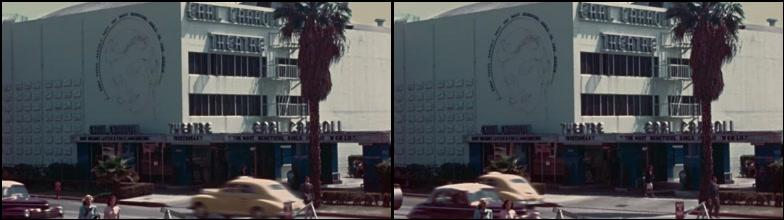

Description: The scene shows an exterior view of a building with a sign that says 'The Troubadour'. There are palm trees and cars parked on the street in front of the building. (95%)
Sentiment: Neutral (85%)
Iab_taxonomy: Entertainment (90%)
Garm_taxonomy: None (100%)
Brands_and_logos: None
Relevant_tags: building, palm tree, car, street, sign


==== Chapter #03: Contextual information ======


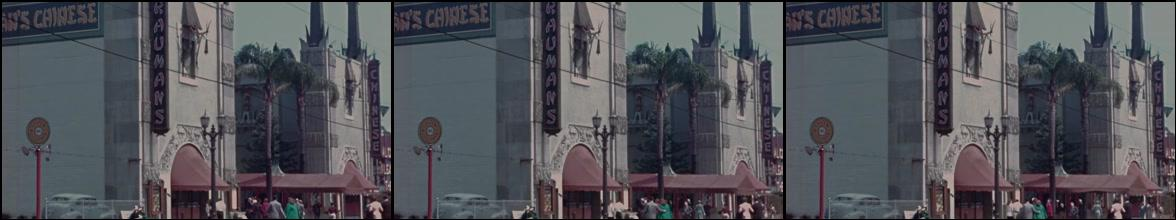

Description: The scene depicts the exterior of a Chinese restaurant or attraction with a large ornate entrance gate and signage that reads 'LV'S CHINESE'. The architecture appears to be in a traditional Chinese style with curved roofs and decorative elements. (95%)
Sentiment: Neutral (90%)
Iab_taxonomy: Attractions (95%)
Garm_taxonomy: None (100%)
Brands_and_logos: None
Relevant_tags: Chinese architecture, Restaurant, Ornate entrance, Traditional design, Tourist attraction


==== Chapter #04: Contextual information ======


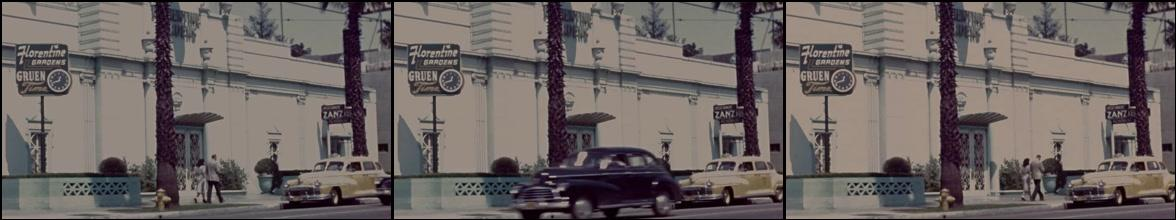

Description: The scene depicts a street view of an urban area with vintage cars parked in front of a building with a neon sign that says 'Flamingo'. (95%)
Sentiment: Neutral (90%)
Iab_taxonomy: Automotive (95%)
Garm_taxonomy: None (100%)
Brands_and_logos: None
Relevant_tags: vintage cars, neon sign, urban street, 1950s, retro


==== Chapter #05: Contextual information ======


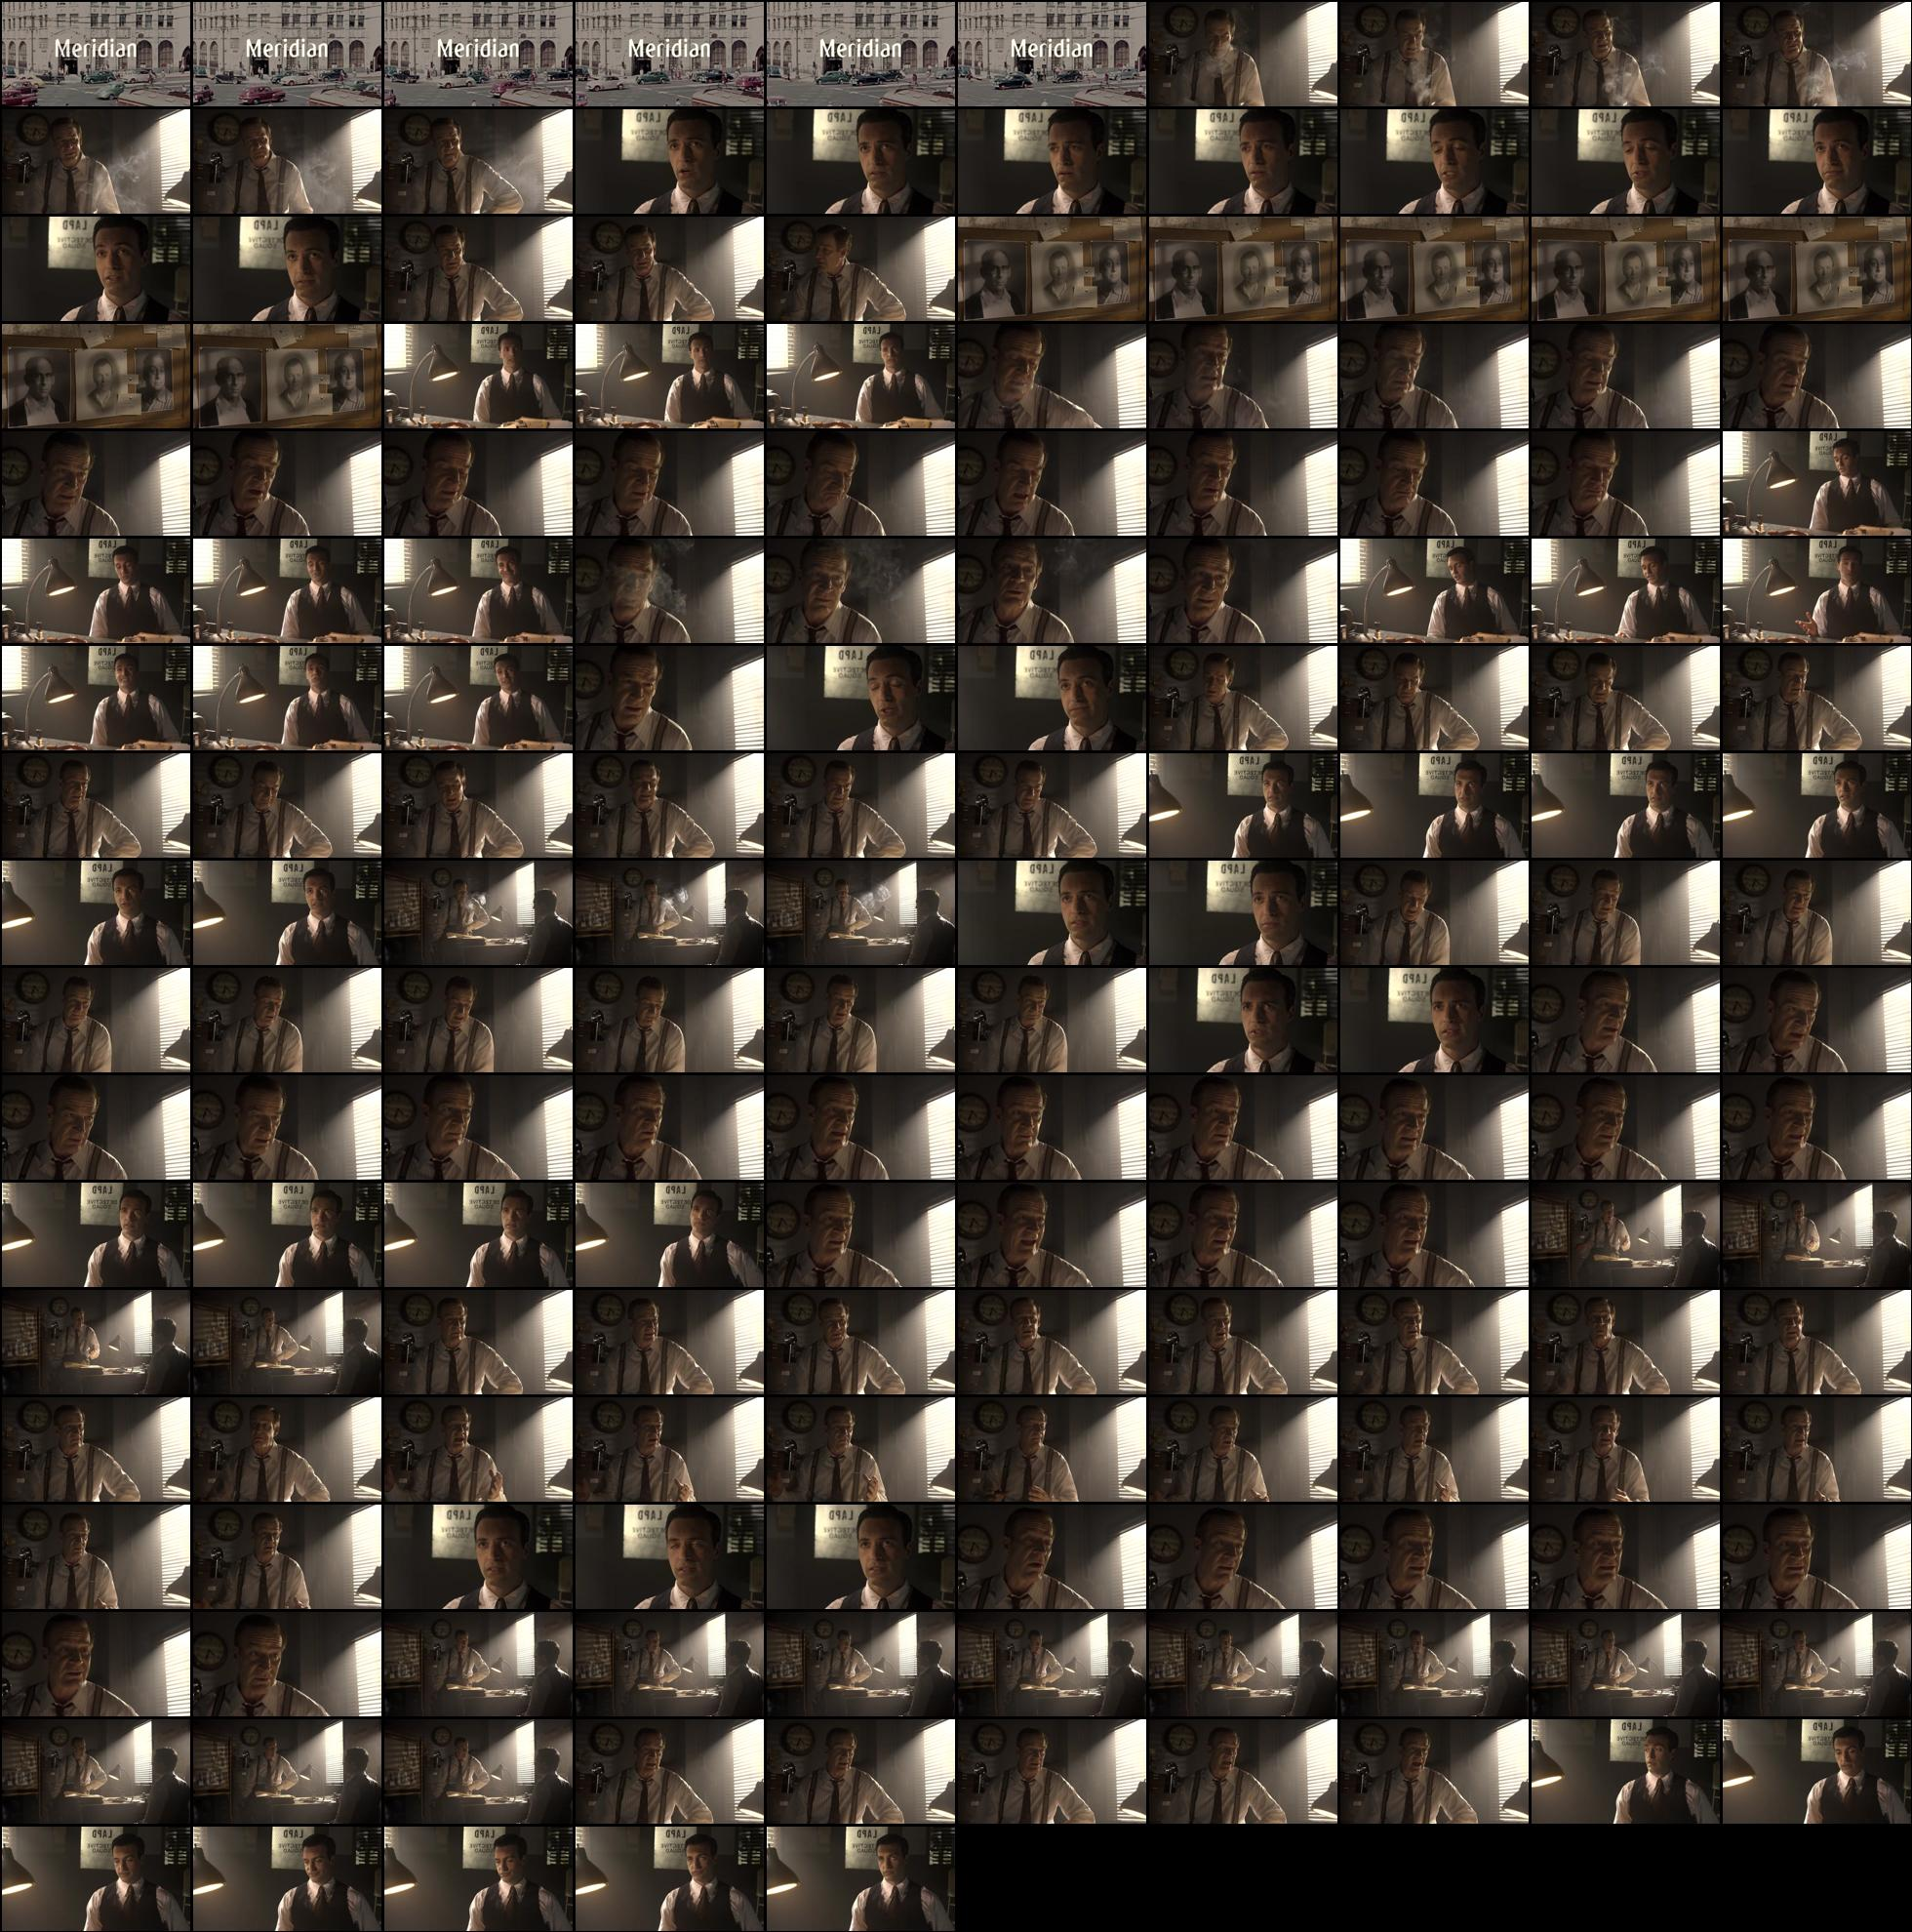

Description: The scene depicts an office setting with a man in a suit sitting at a desk, looking at files and photographs related to a missing persons case. The office has a vintage aesthetic with blinds, lamps, and clocks on the wall suggesting it is a detective's or police officer's workspace. The overall tone is serious and investigative. (95%)
Sentiment: Neutral (90%)
Iab_taxonomy: Crime (85%)
Garm_taxonomy: Crime & Harmful acts to individuals and Society, Human Right Violations (90%)
Brands_and_logos: Meridian
Relevant_tags: investigation, detective, missing persons, vintage office, case files


==== Chapter #06: Contextual information ======


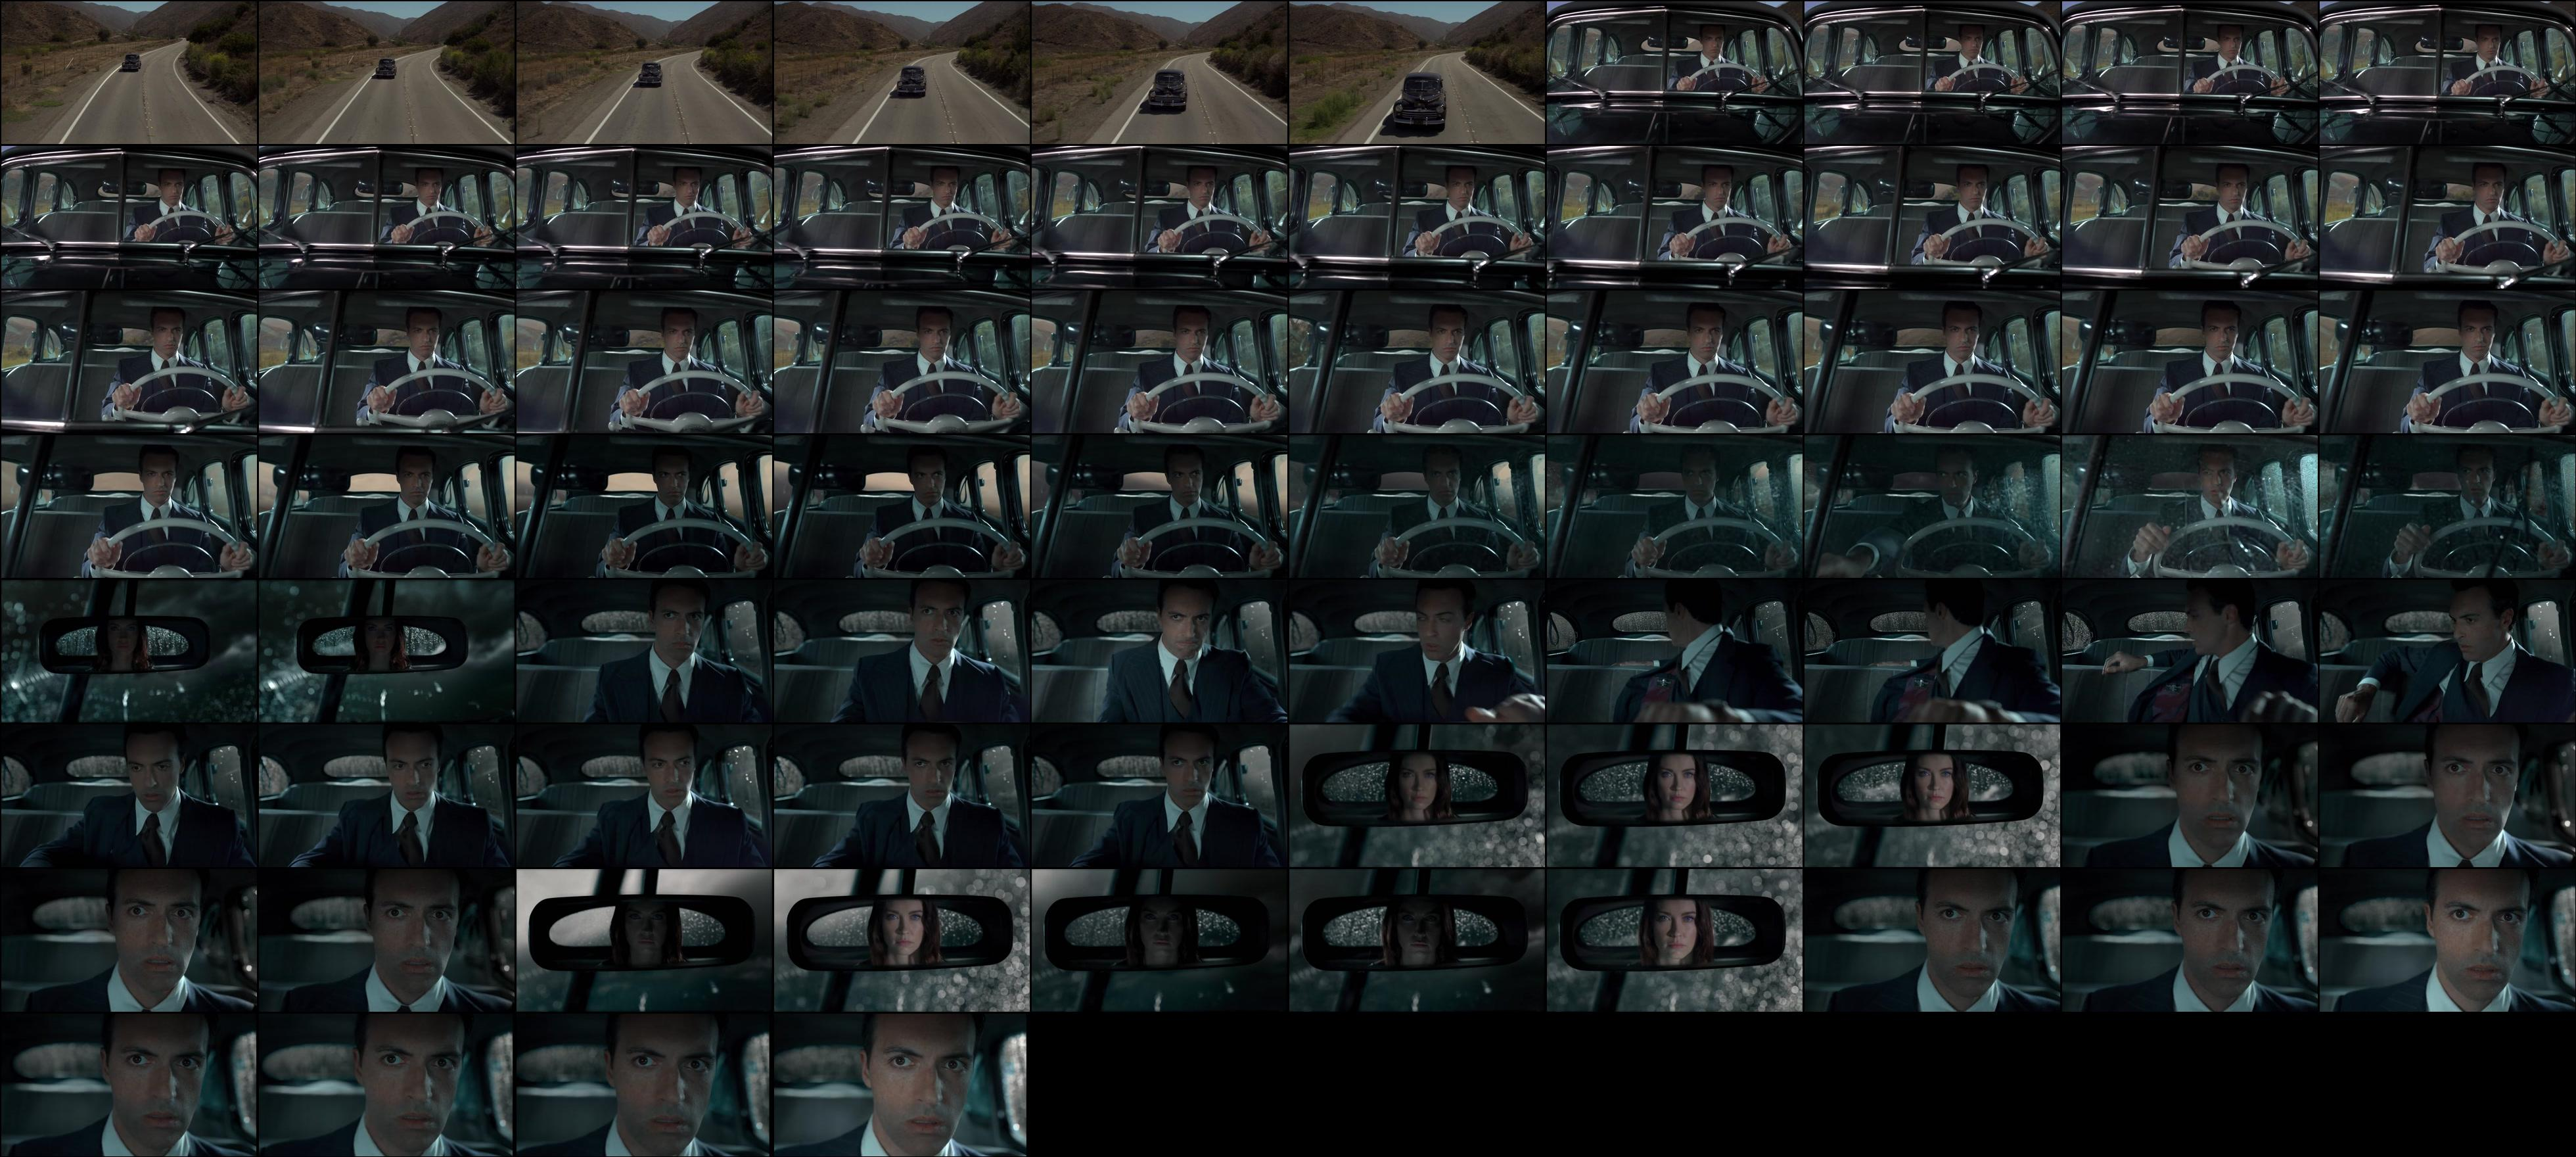

Description: The scene depicts a person dressed formally in a suit and tie driving a black luxury sedan on a desert highway surrounded by arid landscapes. The frames show the person's focused expression while gripping the steering wheel. (95%)
Sentiment: Neutral (90%)
Iab_taxonomy: Automotive (95%)
Garm_taxonomy: None (95%)
Brands_and_logos: None
Relevant_tags: driving, luxury car, desert road, formal attire, focused expression


==== Chapter #07: Contextual information ======


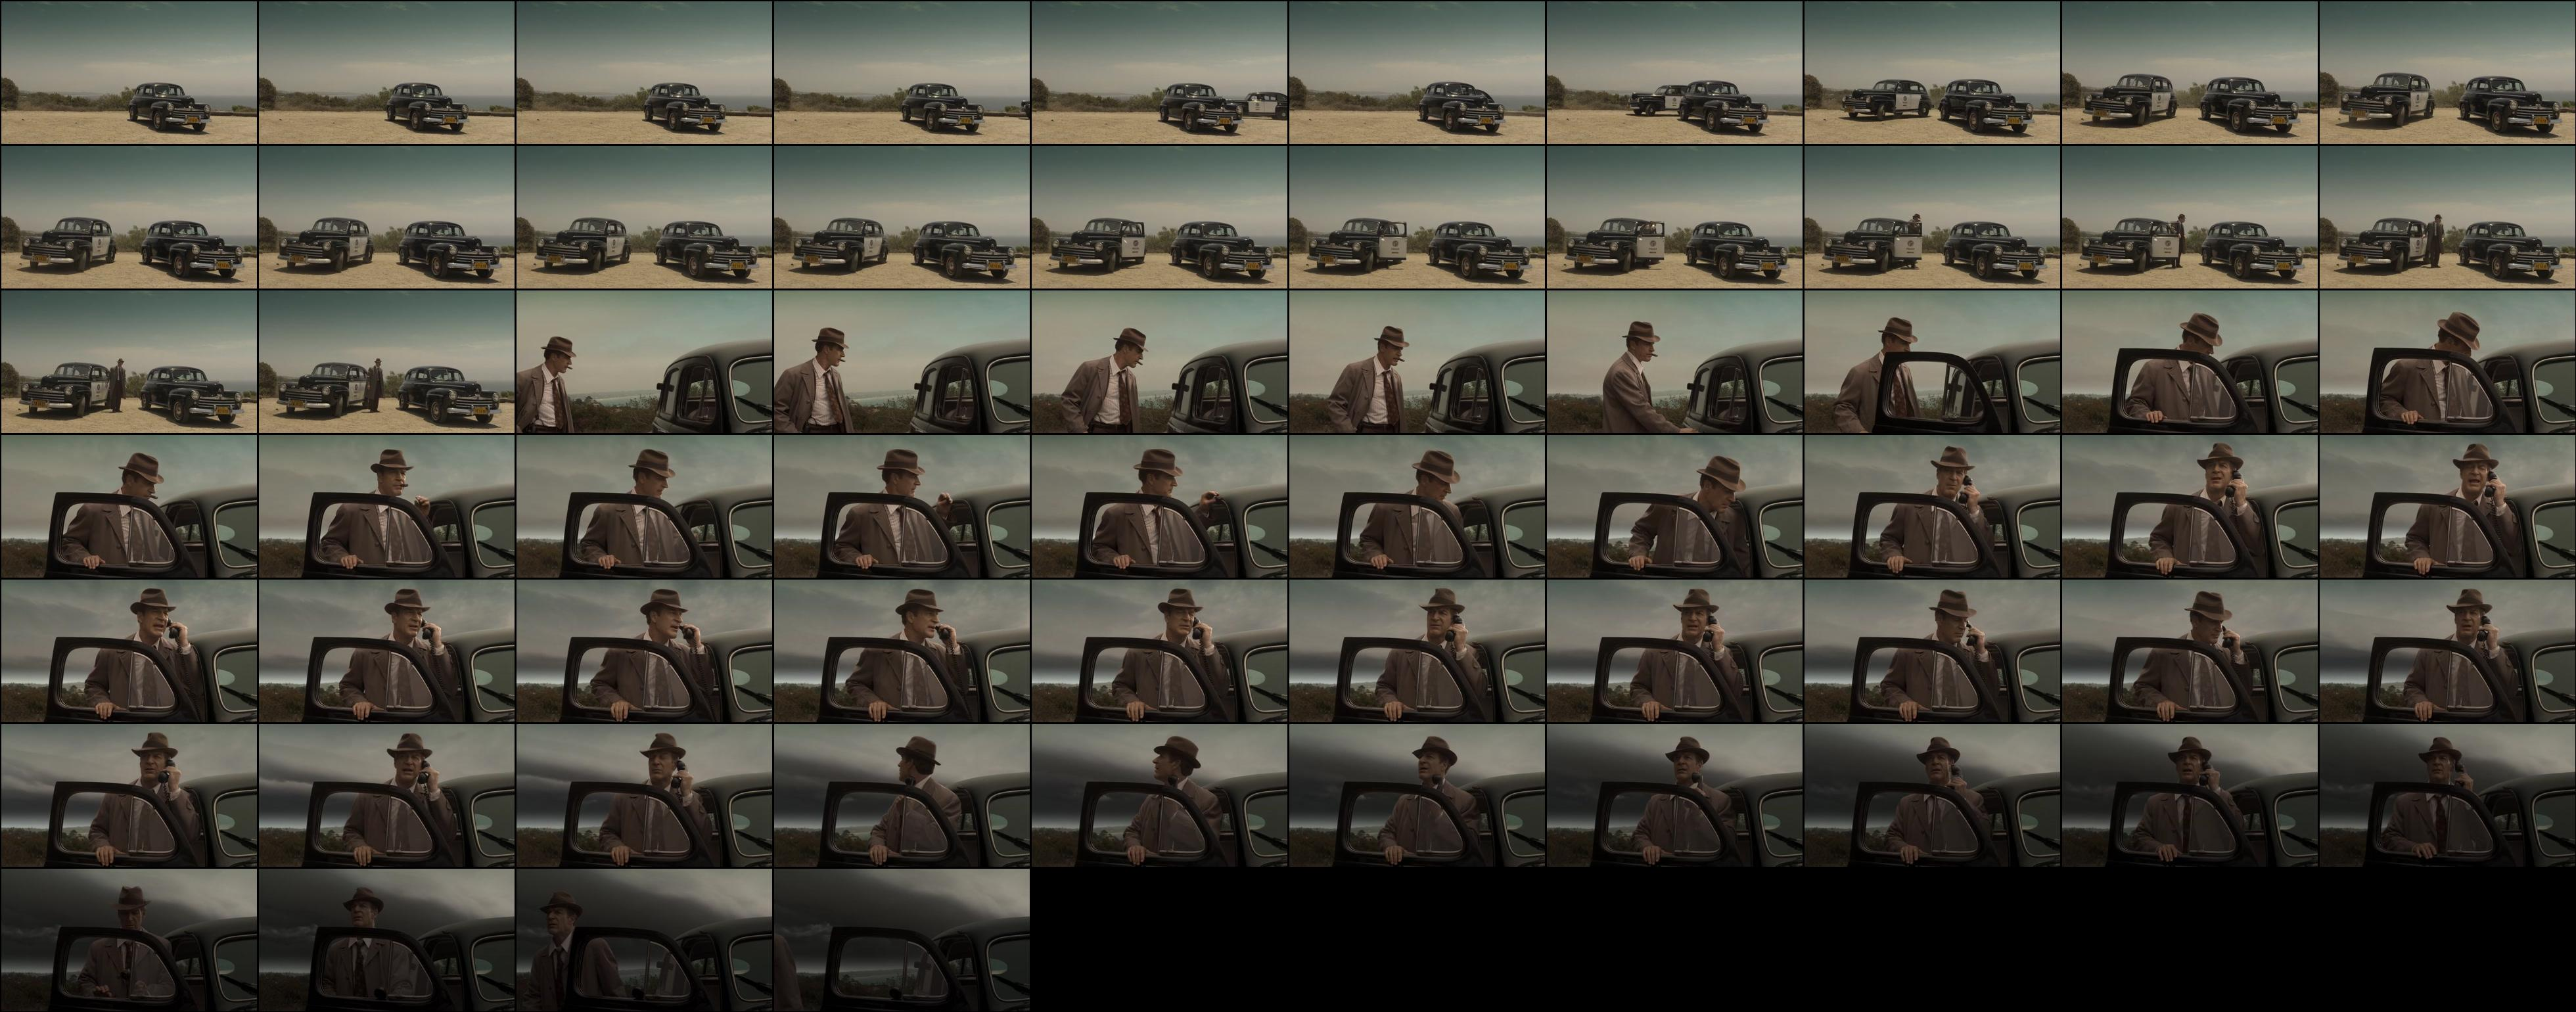

Description: The scene depicts a man in a vintage suit and hat sitting in an old car in a desert landscape. The sequence of frames shows him getting into the car, sitting down, and then lighting a cigarette while looking pensive. (95%)
Sentiment: Neutral (90%)
Iab_taxonomy: Automotive (95%)
Garm_taxonomy: None (100%)
Brands_and_logos: None
Relevant_tags: vintage car, desert, smoking, retro fashion, contemplative


==== Chapter #08: Contextual information ======


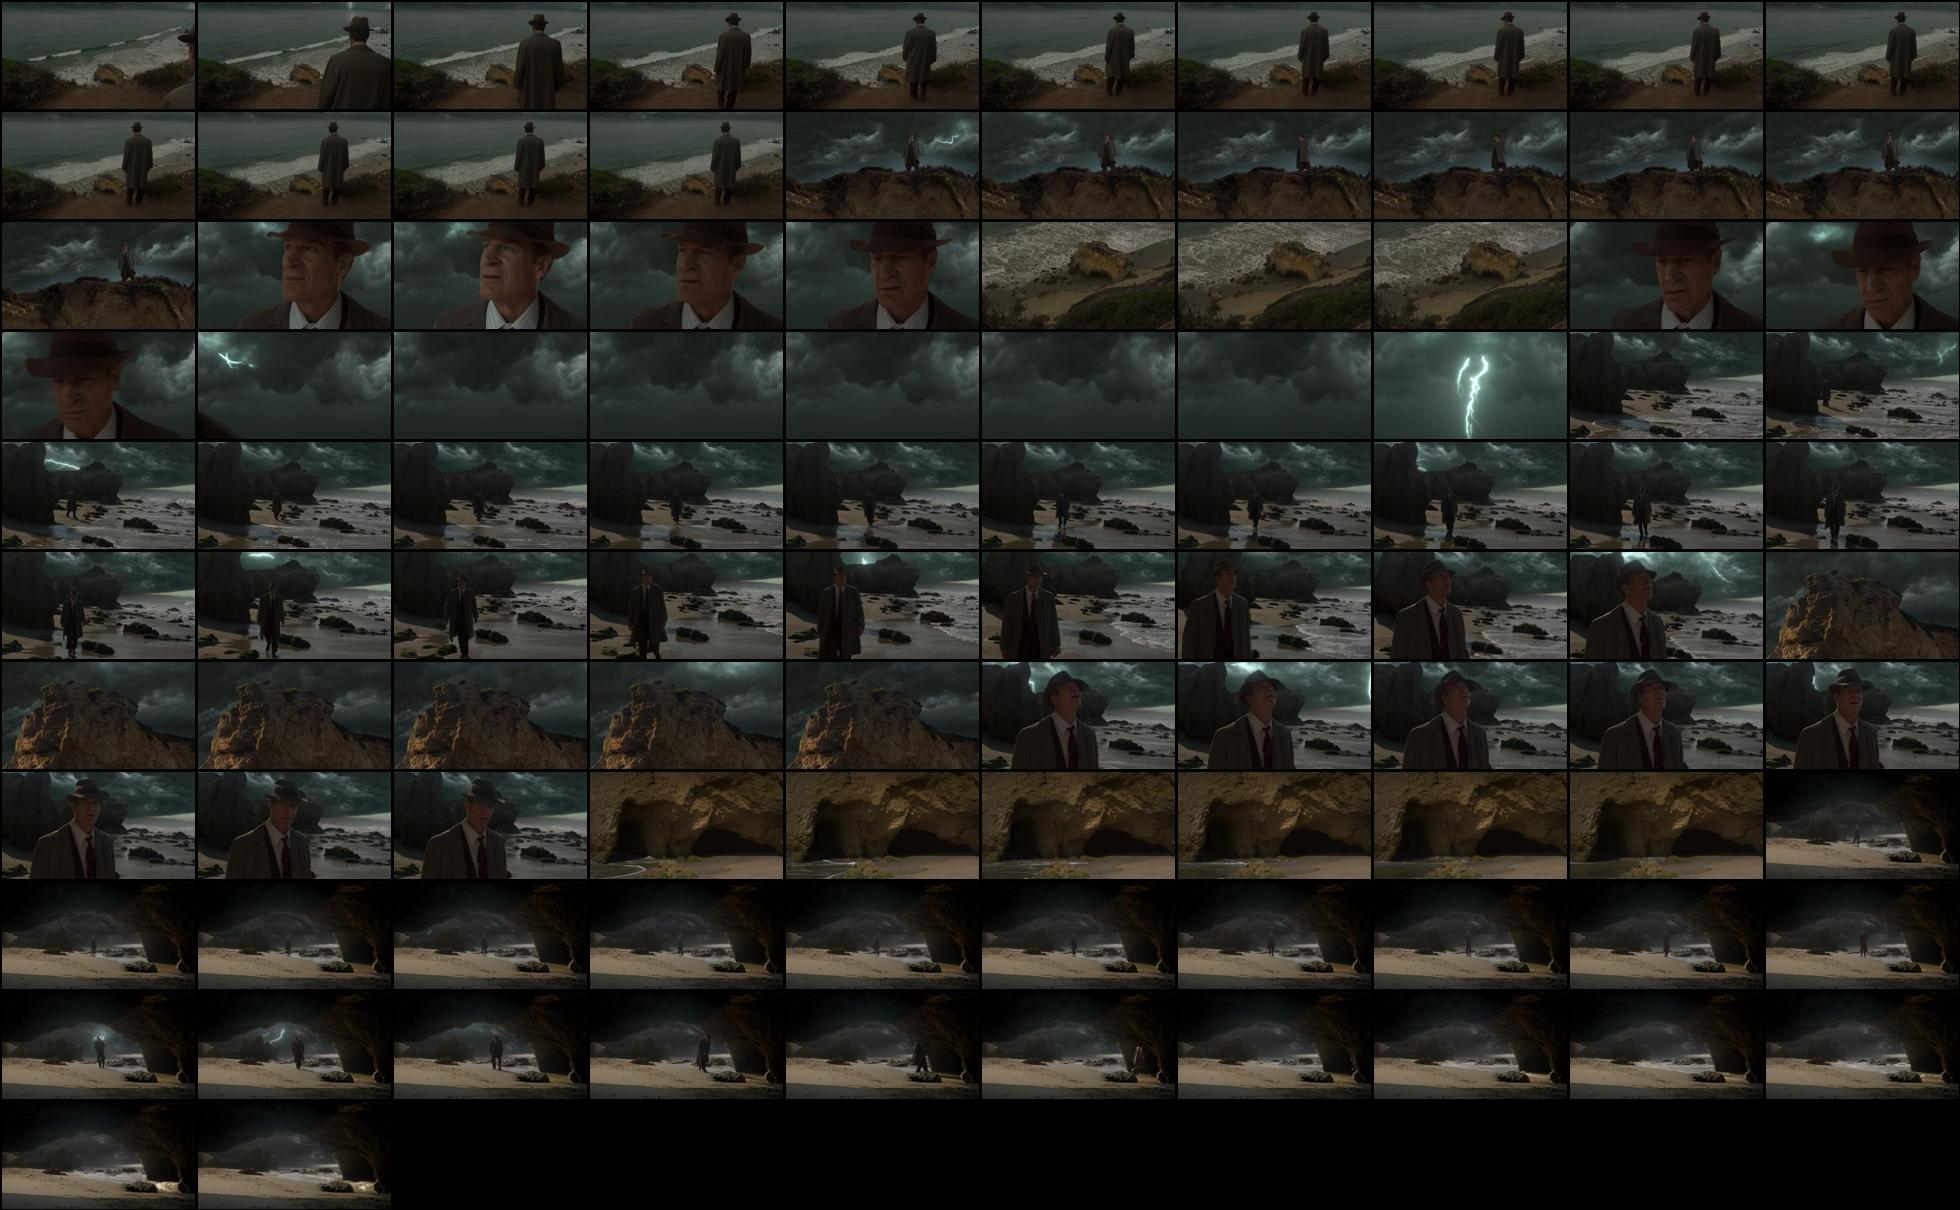

Description: The scene depicts a person wearing a suit and hat standing alone on a rocky beach, with dark storm clouds and lightning in the sky behind them. The person has a pensive or contemplative expression as they gaze out at the stormy sea. (95%)
Sentiment: Neutral (90%)
Iab_taxonomy: Nature (85%)
Garm_taxonomy: None (95%)
Brands_and_logos: None
Relevant_tags: beach, storm, ocean, lightning, contemplation


==== Chapter #09: Contextual information ======


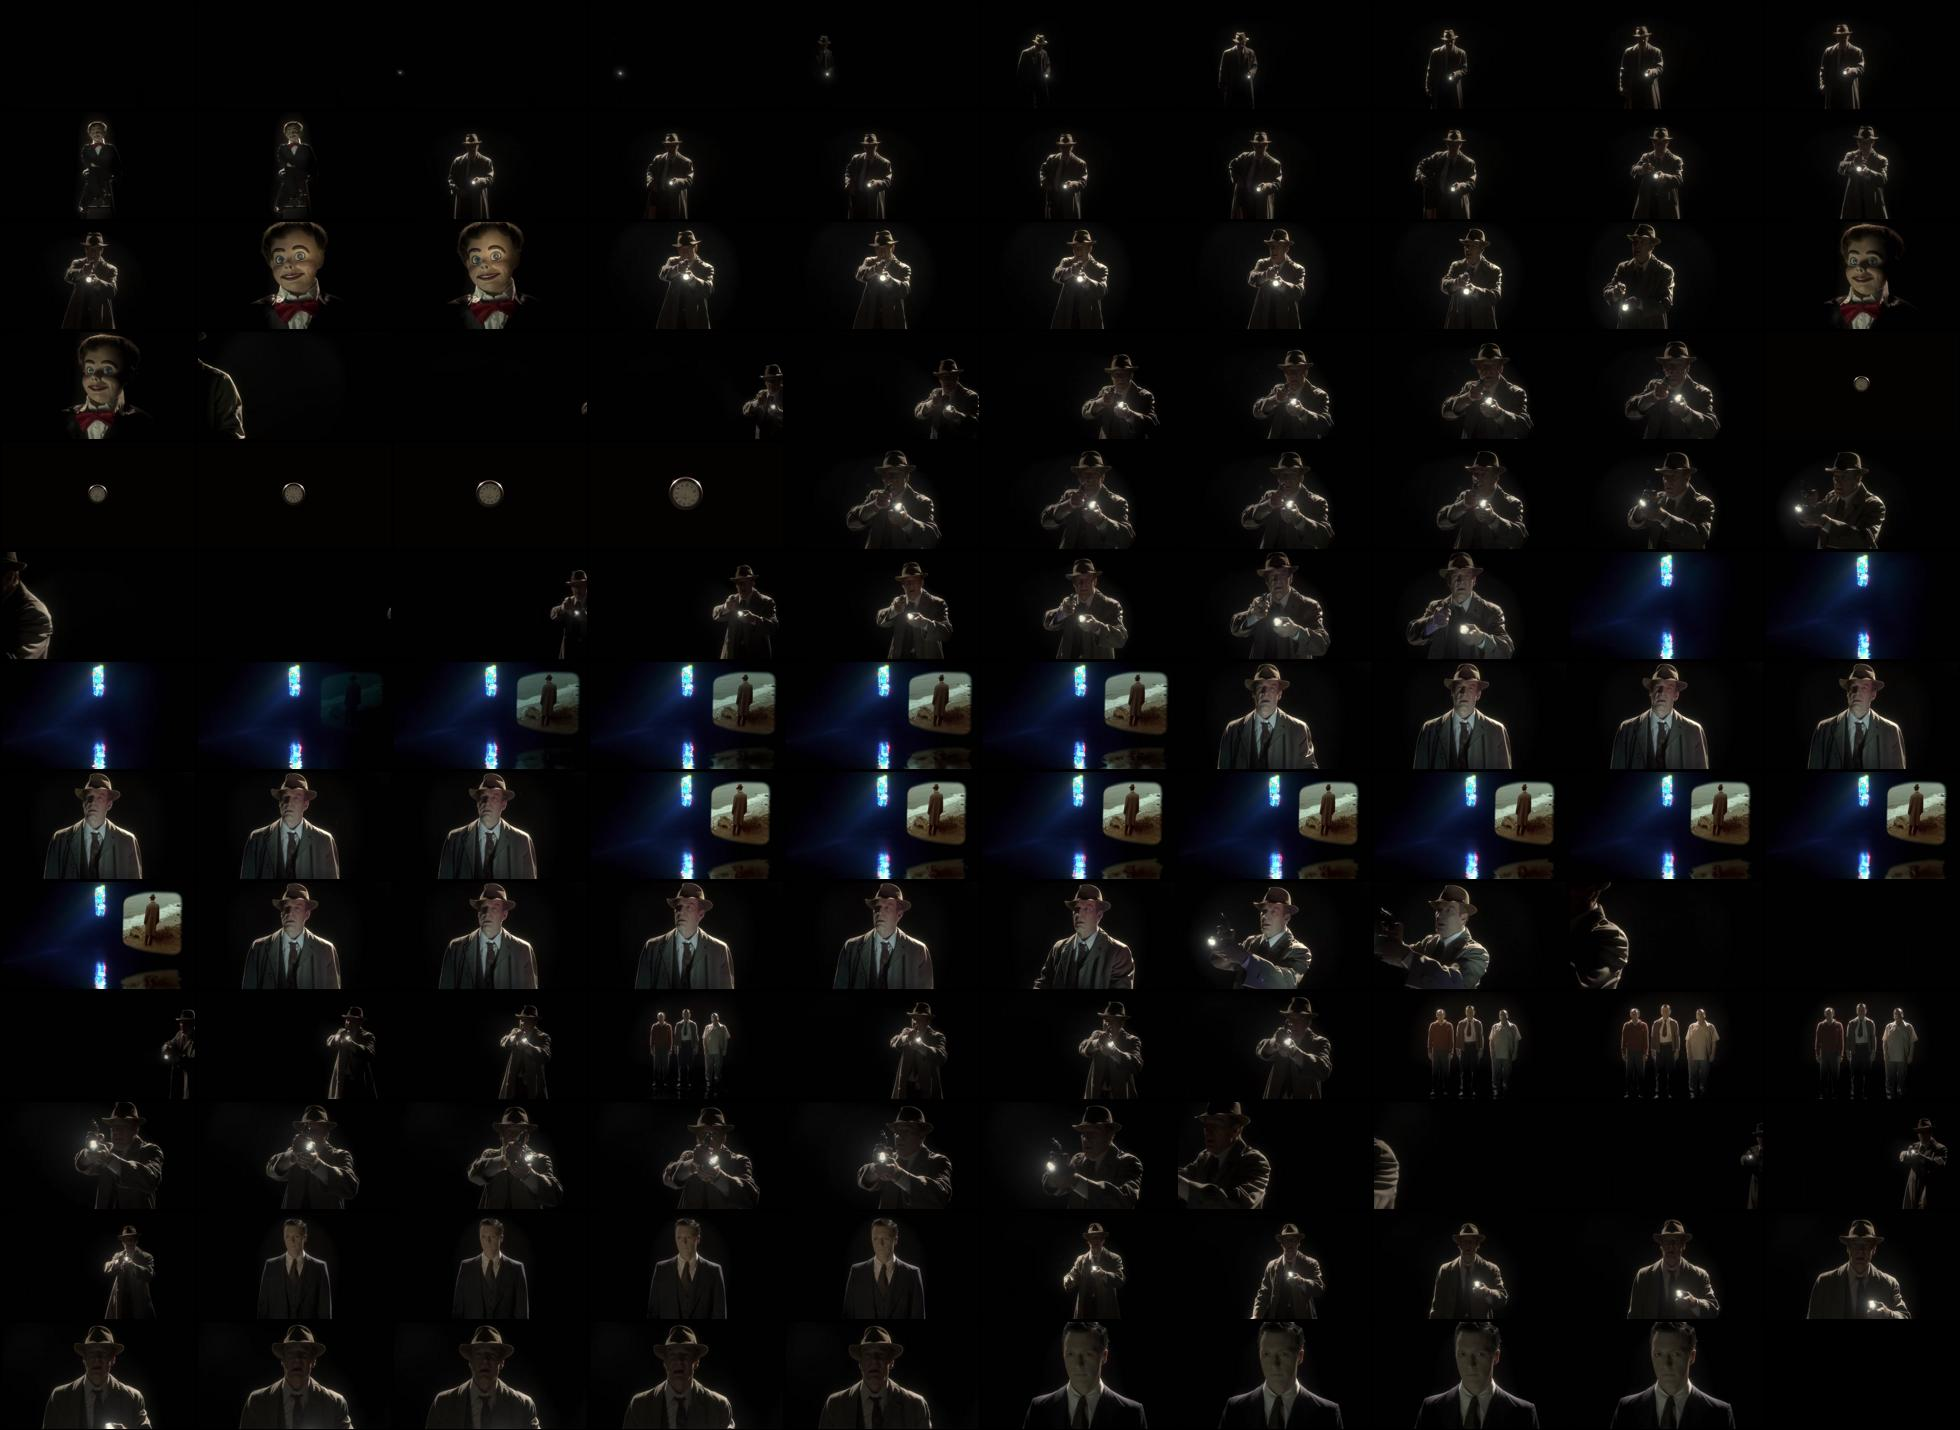

Description: The scene depicts a series of figures in silhouette against a black background. The figures appear to be men in suits and hats, with some variation in their poses and expressions. A recurring motif is a ventriloquist dummy figure with an exaggerated grin. Towards the end, images of a lone man in a desert landscape are shown on screens, suggesting a connection or transition between the two scenarios. (95%)
Sentiment: Neutral (90%)
Iab_taxonomy: Entertainment (85%)
Garm_taxonomy: None (95%)
Brands_and_logos: None
Relevant_tags: silhouette, ventriloquist dummy, suits, desert landscape, screens


==== Chapter #10: Contextual information ======


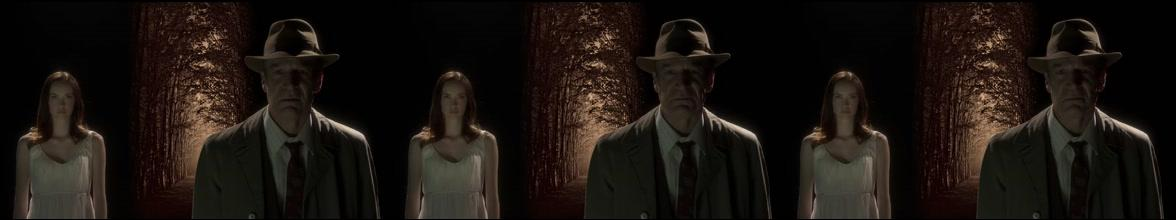

Description: The scene depicts two people, a man and a woman, standing in a dimly lit environment with a tree trunk or wooden surface behind them. The man is wearing a suit, tie, and hat, while the woman is wearing a light-colored dress. Their expressions are neutral, and they appear to be posing for a photograph or scene. (95%)
Sentiment: Neutral (90%)
Iab_taxonomy: Entertainment (85%)
Garm_taxonomy: None (95%)
Brands_and_logos: None
Relevant_tags: portrait, vintage, noir, mystery, suspense


==== Chapter #11: Contextual information ======


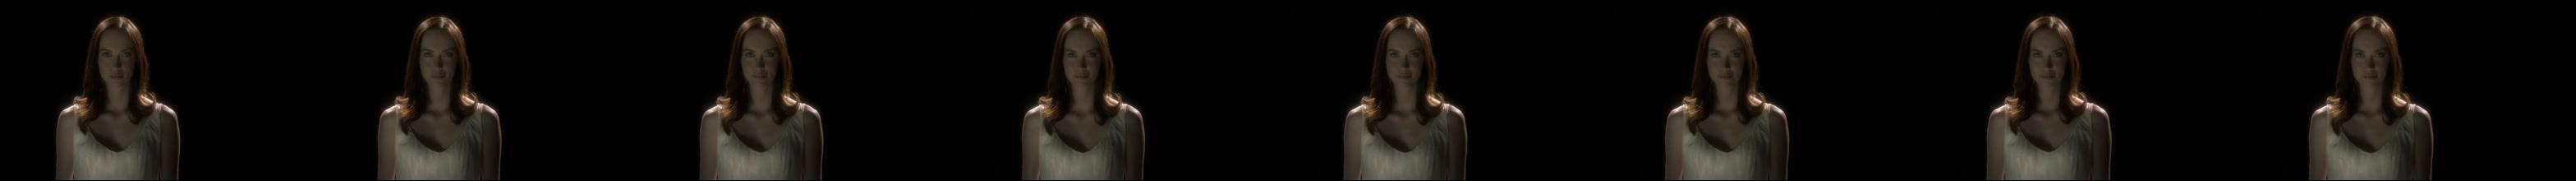

Description: The scene shows a woman with long brown hair wearing a white top against a black background. She has a neutral facial expression and is looking straight ahead. (95%)
Sentiment: Neutral (90%)
Iab_taxonomy: None (95%)
Garm_taxonomy: None (95%)
Brands_and_logos: None
Relevant_tags: woman, portrait, brunette, white top, black background


==== Chapter #12: Contextual information ======


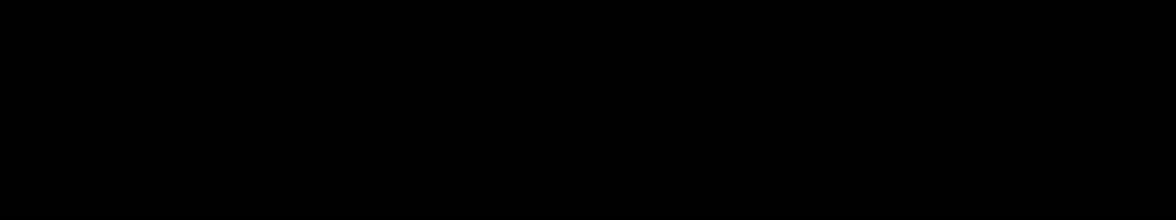

Description: The scene shows a completely dark image with no visible content. (100%)
Sentiment: Neutral (100%)
Iab_taxonomy: None (100%)
Garm_taxonomy: None (100%)
Brands_and_logos: None
Relevant_tags: None


==== Chapter #13: Contextual information ======


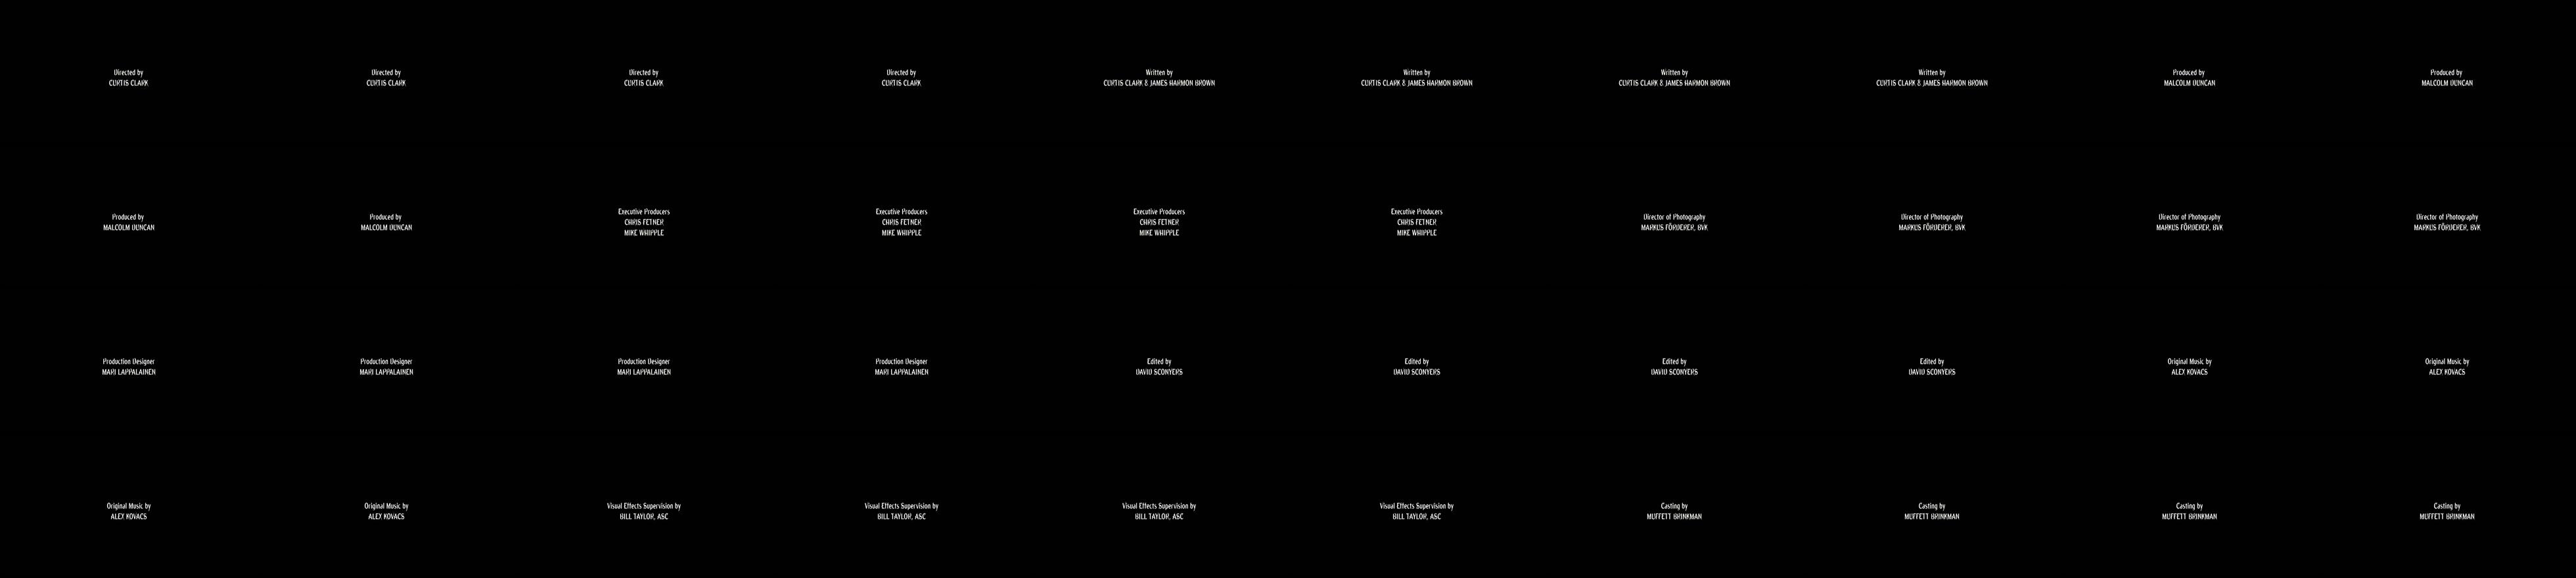

Description: The scene shows a black background with credits for a film or video production, including the director, writers, producers, editors, and other crew members. (100%)
Sentiment: Neutral (100%)
Iab_taxonomy: Entertainment (95%)
Garm_taxonomy: None (100%)
Brands_and_logos: None
Relevant_tags: movie credits, film production, crew members, black background, text overlay


==== Chapter #14: Contextual information ======


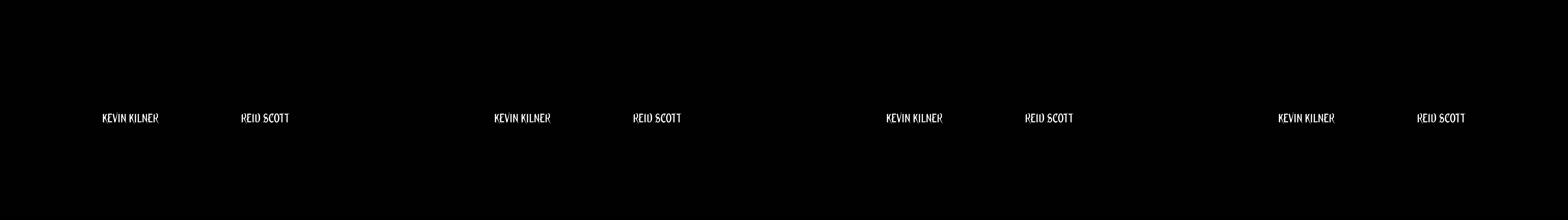

Description: The scene shows a black background with the names 'Kevin Kluep' and 'Jedd Scott' repeated in white text across multiple frames. (100%)
Sentiment: Neutral (100%)
Iab_taxonomy: None (100%)
Garm_taxonomy: None (100%)
Brands_and_logos: None
Relevant_tags: text, names, black background, white text, repeated


==== Chapter #15: Contextual information ======


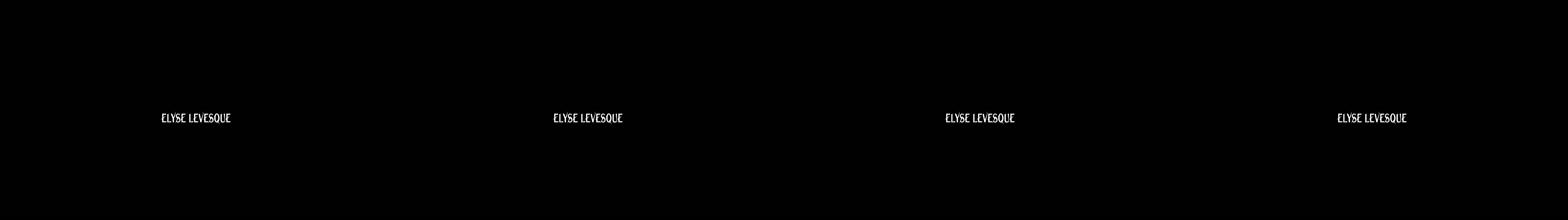

Description: The scene shows a completely black image with the text 'ELYSE LIVESOUE' repeated across the frame. (100%)
Sentiment: Neutral (100%)
Iab_taxonomy: None (100%)
Garm_taxonomy: None (100%)
Brands_and_logos: None
Relevant_tags: black background, text, repetition, minimalist, abstract


==== Chapter #16: Contextual information ======


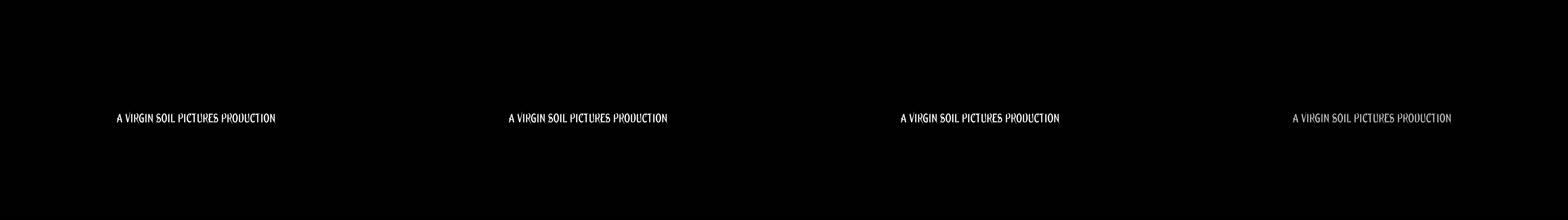

Description: The scene shows a black background with the text 'A VIRGIN SOIL PICTURES PRODUCTION' repeated across multiple frames. (100%)
Sentiment: Neutral (100%)
Iab_taxonomy: Entertainment (90%)
Garm_taxonomy: None (100%)
Brands_and_logos: None
Relevant_tags: movie production, text overlay, black background, intro sequence, film studio


==== Chapter #17: Contextual information ======


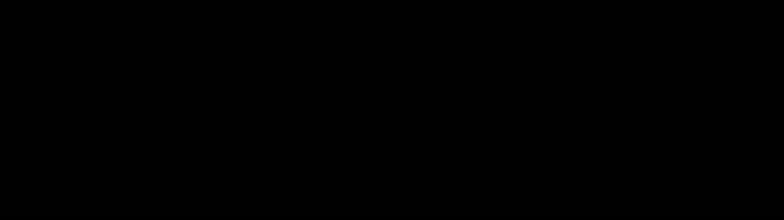

Description: The scene shows a sequence of frames depicting a person sitting at a desk or table working on a laptop computer. The background appears to be an office or home office setting. (95%)
Sentiment: Neutral (90%)
Iab_taxonomy: Technology & Computing (95%)
Garm_taxonomy: None (95%)
Brands_and_logos: None
Relevant_tags: laptop, office, work, computer, desk


==== Chapter #18: Contextual information ======


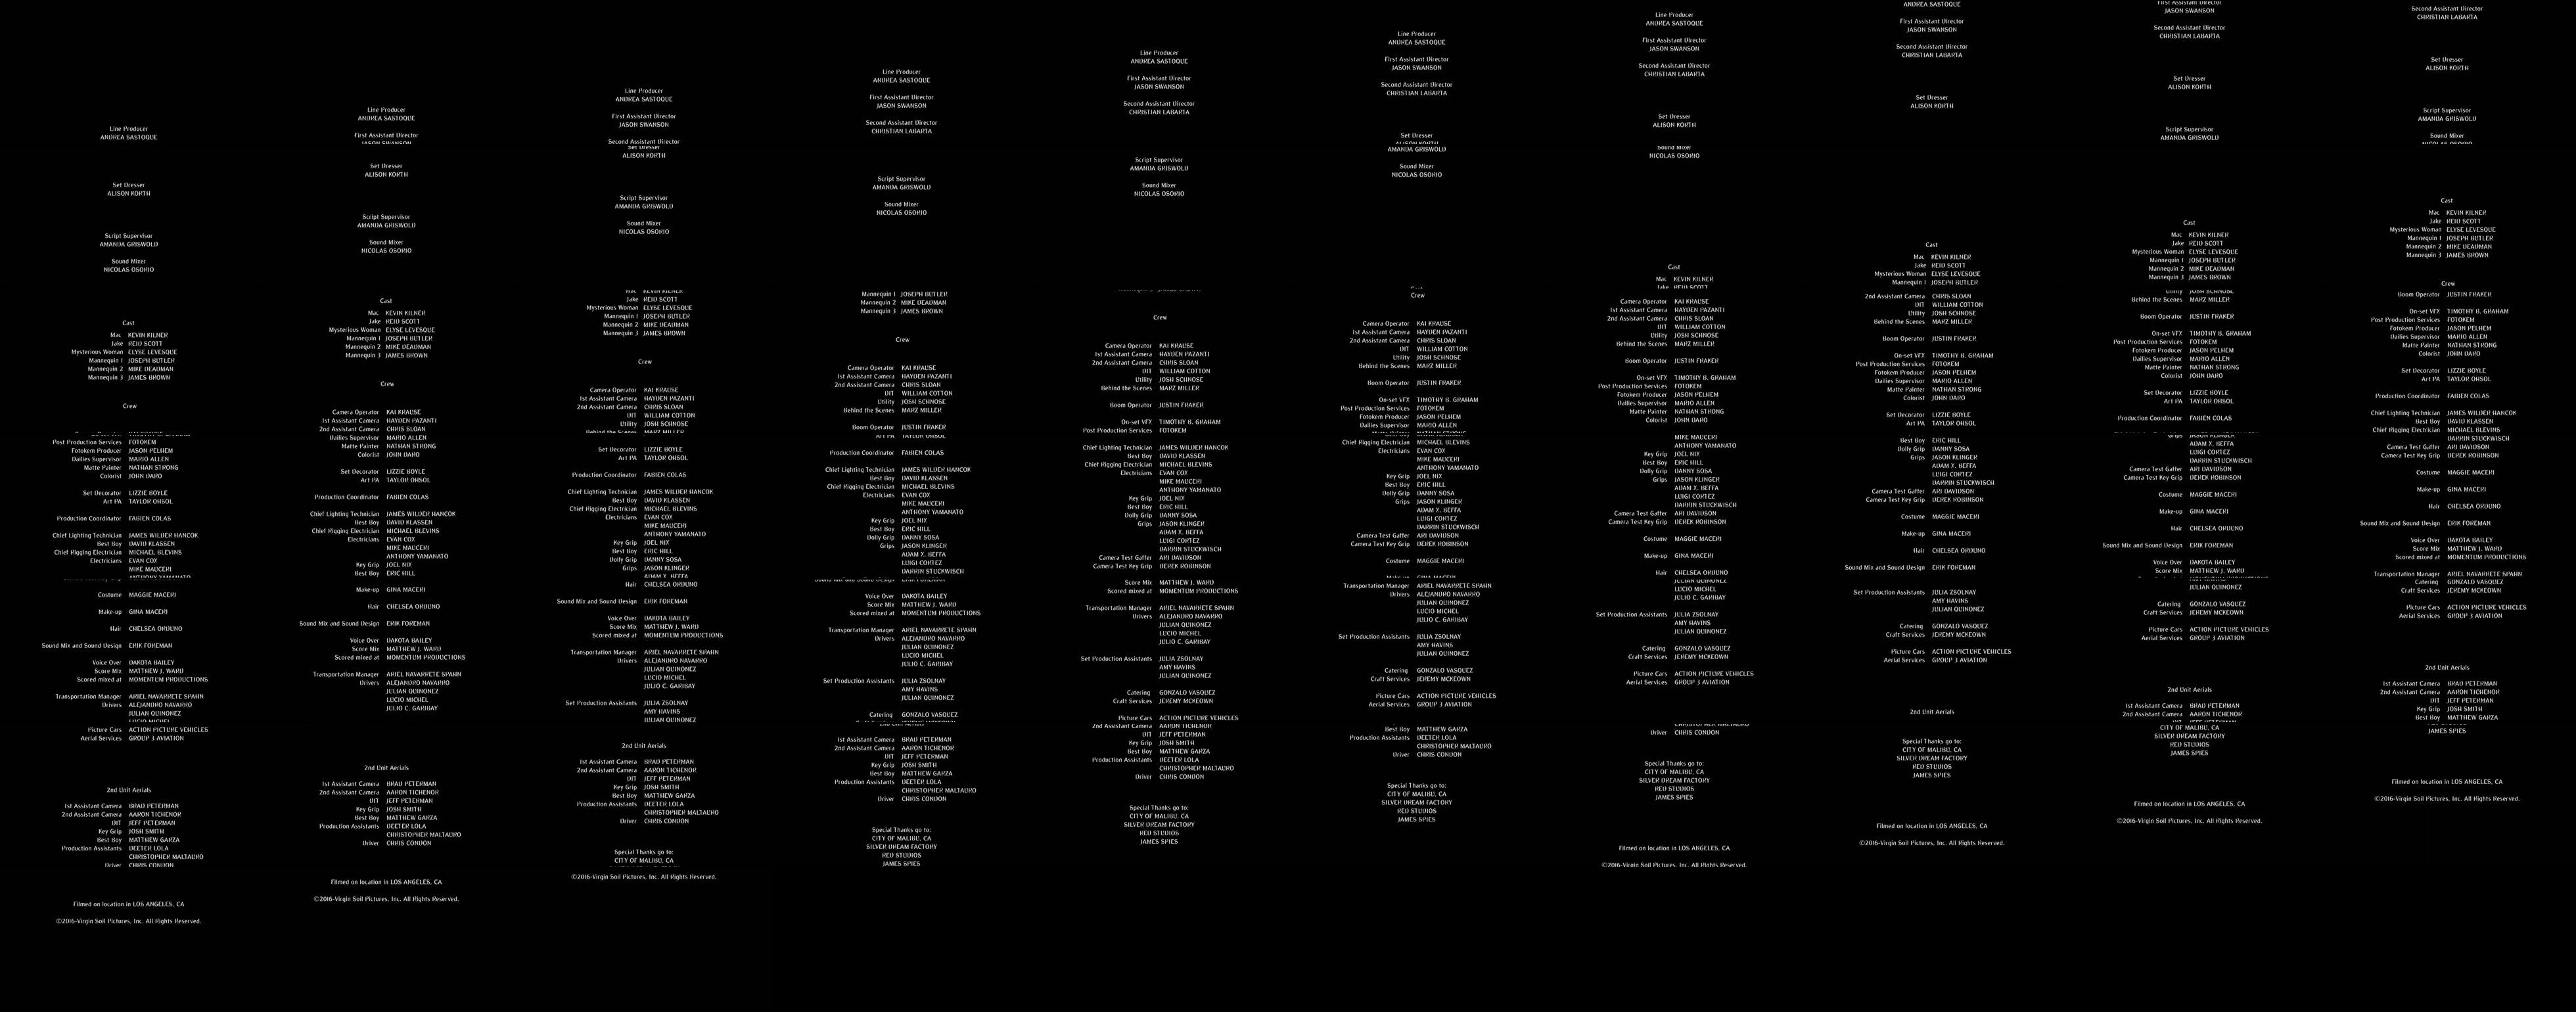

Description: The scene shows a list of credits and crew members involved in the production of a film or TV show. The credits are displayed in a grid format on a black background. (95%)
Sentiment: Neutral (90%)
Iab_taxonomy: Entertainment (95%)
Garm_taxonomy: None (100%)
Brands_and_logos: None
Relevant_tags: movie credits, film production, crew list, end credits, cast and crew


==== Chapter #19: Contextual information ======


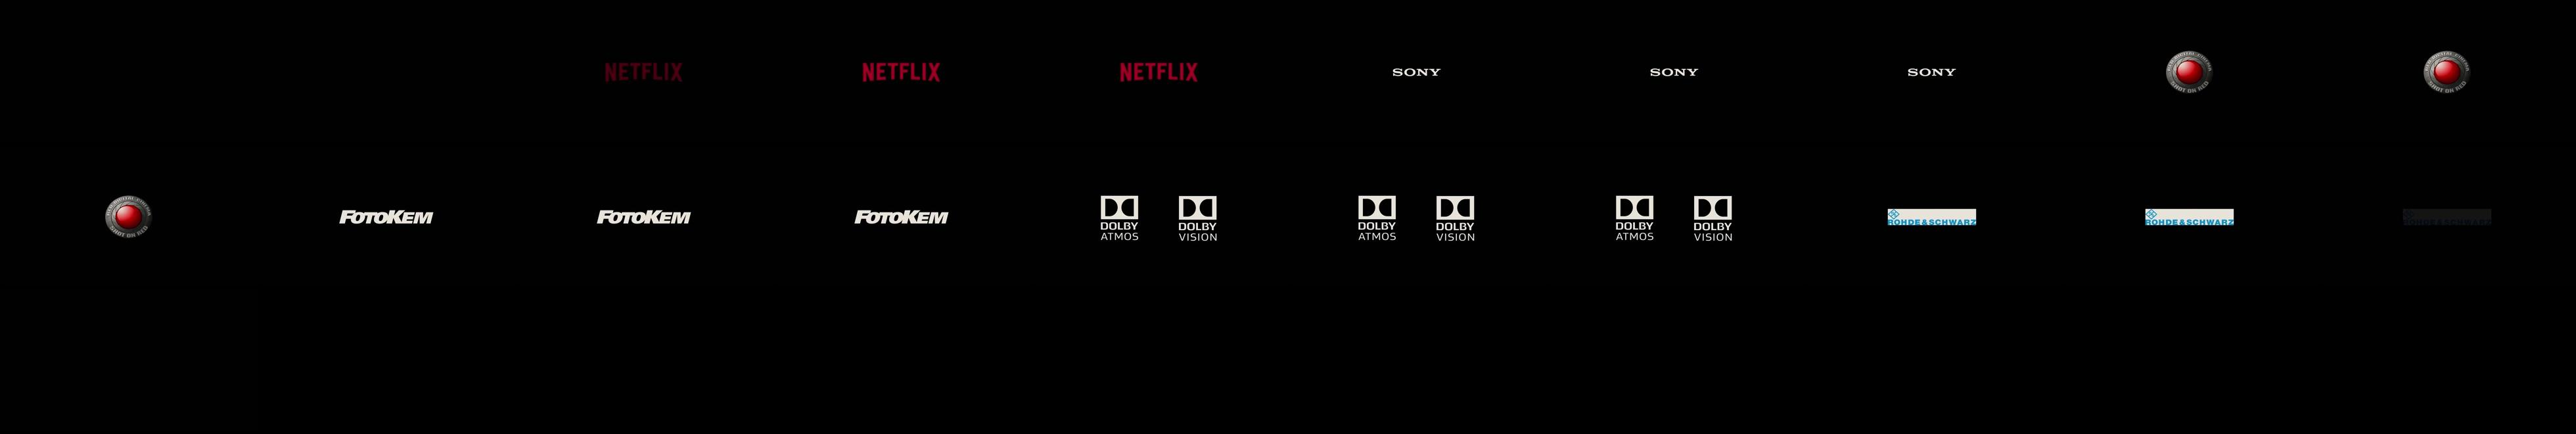

Description: The scene shows a black background with various company logos and branding displayed, including Netflix, Sony, FotoKem, Dolby Atmos, and Sonypictures. (95%)
Sentiment: Neutral (100%)
Iab_taxonomy: Entertainment (95%)
Garm_taxonomy: None (100%)
Brands_and_logos: Netflix, Sony, FotoKem, Dolby Atmos, Sonypictures
Relevant_tags: entertainment, branding, logos, production, media




Estimated cost: $0.271 in us-east-1 region with 62408 input tokens and 5587 output tokens.


In [9]:
import time

total_usage = {
    'input_tokens': 0,
    'output_tokens': 0,
}

iab_definitions = load_iab_taxonomies(iab_file)

for chapter in video['chapters'].chapters:

    composite_images = chapter['composite_images']
    num_images = len(composite_images)

    chapter_id = chapter['id']
    text = chapter['text'] 

    contextual_response = brh.get_contextual_information(composite_images, chapter['text'], iab_definitions)
    time.sleep(5)
    usage = contextual_response['usage']
    contextual = contextual_response['content'][0]['json']

    # save the contextual to the chapter
    chapter['contextual'] = {
        'usage': usage,
        **contextual
    }
    
    total_usage['input_tokens'] += usage['input_tokens']
    total_usage['output_tokens'] += usage['output_tokens']

    print(f"==== Chapter #{chapter['id']:02d}: Contextual information ======")
    video['frames'].display_frames(start=chapter['start_frame_id'], end=chapter['end_frame_id']+1)
    for key in ['description', 'sentiment', 'iab_taxonomy', 'garm_taxonomy']:
        print(f"{key.capitalize()}: {colored(contextual[key]['text'], 'green')} ({contextual[key]['score']}%)")

    for key in ['brands_and_logos', 'relevant_tags']:
        items = ', '.join([item['text'] for item in contextual[key]])
        if len(items) == 0:
            items = 'None'
        print(f"{key.capitalize()}: {colored(items, 'green')}")
    print(f"================================================\n\n")

output_file = os.path.join(video["output_dir"], 'scenes_in_chapters.json')
util.save_to_file(output_file, video['chapters'].chapters)

contextual_cost = brh.display_contextual_cost(total_usage)

## Ad breaks

At this point, we have generated video segments that have clear visual breaks between scenes, and we have grouped the scenes into chapters that have clear breaks between topics from the speech in the audio. The breaks between chapters are all candidate ad placement opportunities.  We can use the IAB taxonomy of the chapter segments adjacent to the breaks to make better decisions about what ad to place in that break.  

Are we done?  It's a good start, but there are additional signals we could use to improve the quality of the breaks or to determine if some breaks are better than others.  Examples:

* We used the speech to segment the video into conversation topics, but we could also use other audio cues, such as silences, to help tune break points.
* We segmented the video into shots and scenes, but we could also separate out the introduction, mid-roll, and credits to avoid ad placement in certain types of segments.
* We could increase or decrease the number of breaks found by creating more or less granular conversation topics.

These are just a few ideas, perhaps you can think of even more.


## Visualize the ad breaks 

In this section, we'll insert a test Ad into one of the breaks to visualize the ad experience.  

In [10]:
import moviepy
from moviepy.editor import VideoFileClip, concatenate_videoclips

adbreak_start = video['chapters'].chapters[9]['start_ms']/1000

clip1 = VideoFileClip("Netflix_Open_Content_Meridian.mp4").subclip(adbreak_start-10, adbreak_start)
clip2 = VideoFileClip("static/images/CountdownClock_0.mp4")
clip3 = VideoFileClip("Netflix_Open_Content_Meridian.mp4").subclip(adbreak_start, adbreak_start+10)
final_clip = concatenate_videoclips([clip1,clip2,clip3], method="compose")
final_clip.write_videofile("ad_break_demo.mp4")

Moviepy - Building video ad_break_demo.mp4.
MoviePy - Writing audio in ad_break_demoTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video ad_break_demo.mp4



Moviepy - Done !
Moviepy - video ready ad_break_demo.mp4


In [11]:
Video(url='ad_break_demo.mp4', width=640, height=360)

